## Search Algorithms

So far we have been using Ray's basic/default Variant Generator in order to perform either:

 - Grid Search
 - Random Search
 
However, Raytune has an expanding suite of options available for different [Search Algortihms](https://docs.ray.io/en/latest/tune-searchalg.html):

 - BayesOpt
 - HyperOpt
 - SigOpt
 - Nevergrad
 - Scikit-Optimize
 - Ax
 - BOHB
 
These bolt in functionality from other well known libraries and make them avilable to us in Raytune. 

Depending on the library that we use there are some customisations needed to use it but these are not in our training code, but centered around how we define the `search space` and call `ray.run`.

### Switch to Bayesian Optimisation

Ray's BayesOpt uses the [bayesian-optimisation](https://github.com/fmfn/BayesianOptimization) package which is already installed in our conda environment





In [2]:
%load_ext autoreload
%autoreload 2

from dependencies import *
from seg_setup_code import *

Loading dependencies we have already seen...
Importing ray...
Done...


Rather than loading bayesopt directly we pull in the tune search algorithm tha wraps it

In [3]:
from ray.tune.suggest.bayesopt import BayesOptSearch

Next we have copied across the same training function from earlier notebooks.

In [4]:
from sklearn.model_selection import LeavePGroupsOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from scipy.signal import medfilt
from filelock import FileLock

def e2e_train_and_test(config, **kwargs):
    
    # threadsafe
#     with FileLock("./data.lock"):
    X, y, groups, X_test, y_test, group_test, well_names = setup(kwargs['filepath'])
    
    # chose your CV strategy
    splitter = LeavePGroupsOut(1)
    
    # run k fold training and validation
    f1_scores = [] # keep hold of all individual scores
    for train_ind, val_ind in splitter.split(X, y, groups=groups):
        pipeline = make_pipeline(RobustScaler(),
                                  XGBClassifier())

        pipeline.set_params(**config)
        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[val_ind])
        
        f1_scores.append(f1_score(y_pred, y[val_ind], average='micro'))
    
        # Clean isolated facies for each well
        y_pred = medfilt(y_pred, kernel_size=5)
    
    # use tunes reporter
    tune.track.log(mean_f1_score=np.array(f1_scores).mean(),
                std_f1_score=np.array(f1_scores).std(),
                # and we can actually add any metrics we like
                done=True)

#### Defining the Search Space

In previous examples we have creates the search space for our tuning job using Raytune's distribution functions.

In [5]:
ray_tuning_config = {
    'xgbclassifier__learning_rate': tune.loguniform(0.001, 0.5),
    'xgbclassifier__max_depth': tune.randint(1, 10),
    'xgbclassifier__min_child_weight': tune.loguniform(0.1, 10),
    'xgbclassifier__n_estimators': tune.randint(5,200),
    'xgbclassifier__colsample_bytree': tune.choice([0.4, 0.6, 0.8, 1.0]),
    'xgbclassifier__lambda': tune.choice([0,1]),
    'xgbclassifier__seed': 42
}

But when using BayesOpt we need to change this and specify:
 - the bounds of the parameter space `pbounds`
 - the form / parameters of a UtilityFunction
 - a modified config object
 
To start with we convert our tuning config to align with pbounds, which uses simple tuples and only suppports *continuous* spaces

In [6]:
pbounds = {
    "xgbclassifier__learning_rate": (0.001, 0.5),
    "xgbclassifier__max_depth": (1, 10),                # Needs to be discrete!
    "xgbclassifier__min_child_weight": (0.1, 100),
    "xgbclassifier__n_estimators": (5, 200),            # Needs to be discrete!
    "xgbclassifier__colsample_bytree": (0.4, 1.0),
    "xgbclassifier__lambda": (0, 1)                     # Needs to be true/false 1/0
}

def parse_config(config):
    config["xgbclassifier__max_depth"] = int(round(config["xgbclassifier__max_depth"]))
    config["xgbclassifier__n_estimators"] = int(round(config["xgbclassifier__n_estimators"]))
    config["xgbclassifier__lambda"] = int(round(config["xgbclassifier__lambda"]))
    return config

In [7]:
utility_fn_kwargs={
    "kind": "ucb",
    "kappa": 2.5,
    "xi": 0.0
}

In [8]:
search_algo = BayesOptSearch(
                pbounds,
                metric="mean_f1_score",
                mode="max",
                utility_kwargs=utility_fn_kwargs)

In [9]:
config = {
    # controls the number of trials
    "num_samples": 100,
    "config": {
        "xgbclassifier__seed": 42,
    },
    "stop": {
        "timesteps_total": 100
    }
}

In [10]:
ray.shutdown()
ray.init(num_cpus=6, num_gpus=0, include_webui=True)

2020-06-05 12:40:33,725	INFO resource_spec.py:204 -- Starting Ray with 4.59 GiB memory available for workers and up to 2.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-05 12:40:34,071	INFO services.py:1168 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.36',
 'raylet_ip_address': '192.168.1.36',
 'redis_address': '192.168.1.36:61351',
 'object_store_address': '/tmp/ray/session_2020-06-05_12-40-33_715238_9796/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-05_12-40-33_715238_9796/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-06-05_12-40-33_715238_9796'}

In [11]:
from os import path
filepath = path.abspath('../datasets/seg_2016_facies/la_team_5_data.h5py')

def e2e_seg(config):
    return e2e_train_and_test(config, filepath=filepath)

def e2e_seg_w_discrete(config):  
    return e2e_seg(
        parse_config(config)
    )

analysis = tune.run(e2e_seg_w_discrete,
                    name="seg_facies_bayes",
                    search_alg=search_algo,
                    **config)

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators
e2e_seg_w_discrete_5e4300cc,PENDING,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618
e2e_seg_w_discrete_5e4346ae,PENDING,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945
e2e_seg_w_discrete_5e4387f4,PENDING,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003
e2e_seg_w_discrete_5e43d40c,PENDING,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238
e2e_seg_w_discrete_5e441b06,PENDING,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255
e2e_seg_w_discrete_5e446566,PENDING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892
e2e_seg_w_discrete_5e44a5f8,PENDING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548
e2e_seg_w_discrete_5e44e7fc,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816
e2e_seg_w_discrete_5e452dc0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5


(pid=9862) 2020-06-05 12:40:37,655	INFO trainable.py:217 -- Getting current IP.
(pid=9866) 2020-06-05 12:40:37,638	INFO trainable.py:217 -- Getting current IP.
(pid=9865) 2020-06-05 12:40:37,638	INFO trainable.py:217 -- Getting current IP.
(pid=9863) 2020-06-05 12:40:37,638	INFO trainable.py:217 -- Getting current IP.
(pid=9864) 2020-06-05 12:40:37,638	INFO trainable.py:217 -- Getting current IP.
(pid=9867) 2020-06-05 12:40:37,641	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e42a2b2:
  date: 2020-06-05_12-40-51
  done: true
  experiment_id: 9a182d1d25844a769f20f8295b281b36
  experiment_tag: 1_xgbclassifier__colsample_bytree=0.65021,xgbclassifier__lambda=0.72032,xgbclassifier__learning_rate=0.0010571,xgbclassifier__max_depth=3.721,xgbclassifier__min_child_weight=14.761,xgbclassifier__n_estimators=23.006,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5183297420845138
  node_ip: 192.168.1.36
  pid

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e446566,PENDING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_5e44a5f8,PENDING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,,
e2e_seg_w_discrete_5e44e7fc,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_5e452dc0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e45b664,PENDING,,0.798277,0.514889,0.472353,6.279,90.3499,31.8076,,
e2e_seg_w_discrete_5e45ff02,PENDING,,0.483566,0.807391,0.199441,2.48819,92.7581,72.8143,,
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,


(pid=9883) 2020-06-05 12:40:53,077	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e441b06:
  date: 2020-06-05_12-41-00
  done: true
  experiment_id: f50f8e38abd24911b7b505782afa7446
  experiment_tag: 6_xgbclassifier__colsample_bytree=0.45901,xgbclassifier__lambda=0.42111,xgbclassifier__learning_rate=0.47899,xgbclassifier__max_depth=5.7985,xgbclassifier__min_child_weight=69.219,xgbclassifier__n_estimators=66.526,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5504309701267032
  node_ip: 192.168.1.36
  pid: 9867
  std_f1_score: 0.06002680219245778
  time_since_restore: 22.790141820907593
  time_this_iter_s: 22.790141820907593
  time_total_s: 22.790141820907593
  timestamp: 1591357260
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e441b06
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e44a5f8,PENDING,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,,
e2e_seg_w_discrete_5e44e7fc,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_5e452dc0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e45b664,PENDING,,0.798277,0.514889,0.472353,6.279,90.3499,31.8076,,
e2e_seg_w_discrete_5e45ff02,PENDING,,0.483566,0.807391,0.199441,2.48819,92.7581,72.8143,,
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,


(pid=9882) 2020-06-05 12:41:01,684	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e43d40c:
  date: 2020-06-05_12-41-18
  done: true
  experiment_id: ad7b629abac1469a911441a9274a2656
  experiment_tag: 5_xgbclassifier__colsample_bytree=0.92583,xgbclassifier__lambda=0.89461,xgbclassifier__learning_rate=0.043437,xgbclassifier__max_depth=1.3515,xgbclassifier__min_child_weight=17.066,xgbclassifier__n_estimators=176.24,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5079373768997704
  node_ip: 192.168.1.36
  pid: 9862
  std_f1_score: 0.11719861628741075
  time_since_restore: 41.01624894142151
  time_this_iter_s: 41.01624894142151
  time_total_s: 41.01624894142151
  timestamp: 1591357278
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e43d40c
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e44e7fc,PENDING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,
e2e_seg_w_discrete_5e452dc0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e45b664,PENDING,,0.798277,0.514889,0.472353,6.279,90.3499,31.8076,,
e2e_seg_w_discrete_5e45ff02,PENDING,,0.483566,0.807391,0.199441,2.48819,92.7581,72.8143,,
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


(pid=9881) 2020-06-05 12:41:20,174	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e44a5f8:
  date: 2020-06-05_12-41-29
  done: true
  experiment_id: 02250de32b7e42b682829c4b5a128325
  experiment_tag: 8_xgbclassifier__colsample_bytree=0.56827,xgbclassifier__lambda=0.78928,xgbclassifier__learning_rate=0.05251,xgbclassifier__max_depth=5.031,xgbclassifier__min_child_weight=90.869,xgbclassifier__n_estimators=62.255,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5045599920746585
  node_ip: 192.168.1.36
  pid: 9882
  std_f1_score: 0.15757015873445
  time_since_restore: 28.10002899169922
  time_this_iter_s: 28.10002899169922
  time_total_s: 28.10002899169922
  timestamp: 1591357289
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e44a5f8
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e452dc0,PENDING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e45b664,PENDING,,0.798277,0.514889,0.472353,6.279,90.3499,31.8076,,
e2e_seg_w_discrete_5e45ff02,PENDING,,0.483566,0.807391,0.199441,2.48819,92.7581,72.8143,,
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,


(pid=9880) 2020-06-05 12:41:31,307	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4346ae:
  date: 2020-06-05_12-41-44
  done: true
  experiment_id: e1bc266d2d584198873ed3546e59ce99
  experiment_tag: 3_xgbclassifier__colsample_bytree=0.52267,xgbclassifier__lambda=0.87812,xgbclassifier__learning_rate=0.014666,xgbclassifier__max_depth=7.0342,xgbclassifier__min_child_weight=41.789,xgbclassifier__n_estimators=113.94,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.537873885887697
  node_ip: 192.168.1.36
  pid: 9865
  std_f1_score: 0.0848577192577969
  time_since_restore: 66.63078618049622
  time_this_iter_s: 66.63078618049622
  time_total_s: 66.63078618049622
  timestamp: 1591357304
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4346ae
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e456dee,PENDING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e45b664,PENDING,,0.798277,0.514889,0.472353,6.279,90.3499,31.8076,,
e2e_seg_w_discrete_5e45ff02,PENDING,,0.483566,0.807391,0.199441,2.48819,92.7581,72.8143,,
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,
e2e_seg_w_discrete_5e47c09e,PENDING,,0.4396,0.755463,0.377184,9.30722,71.1813,29.2328,,


Result for e2e_seg_w_discrete_5e4300cc:
  date: 2020-06-05_12-41-44
  done: true
  experiment_id: b91f44aa330c40c98c4bd8b3bc367098
  experiment_tag: 2_xgbclassifier__colsample_bytree=0.51176,xgbclassifier__lambda=0.34556,xgbclassifier__learning_rate=0.19899,xgbclassifier__max_depth=5.8494,xgbclassifier__min_child_weight=41.978,xgbclassifier__n_estimators=138.62,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5645771592297513
  node_ip: 192.168.1.36
  pid: 9864
  std_f1_score: 0.06927071637279414
  time_since_restore: 67.29182004928589
  time_this_iter_s: 67.29182004928589
  time_total_s: 67.29182004928589
  timestamp: 1591357304
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4300cc
  
(pid=9879) 2020-06-05 12:41:45,608	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4387f4:
  date: 2020-06-05_12-41-45
  done: true
  experiment_id: 201ab8d6c1e5450a94f0a842750a97c6
  experiment_t

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e463ff8,PENDING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,
e2e_seg_w_discrete_5e46804e,PENDING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,
e2e_seg_w_discrete_5e47c09e,PENDING,,0.4396,0.755463,0.377184,9.30722,71.1813,29.2328,,
e2e_seg_w_discrete_5e47ff64,PENDING,,0.411928,0.026211,0.0151249,3.2159,86.0168,110.072,,
e2e_seg_w_discrete_5e446566,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_5e44e7fc,RUNNING,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,,


Result for e2e_seg_w_discrete_5e45ff02:
  date: 2020-06-05_12-42-05
  done: true
  experiment_id: 16b8f2dc290b4b528802b54445d3ed88
  experiment_tag: 13_xgbclassifier__colsample_bytree=0.48357,xgbclassifier__lambda=0.80739,xgbclassifier__learning_rate=0.19944,xgbclassifier__max_depth=2.4882,xgbclassifier__min_child_weight=92.758,xgbclassifier__n_estimators=72.814,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5418710240619994
  node_ip: 192.168.1.36
  pid: 9970
  std_f1_score: 0.09092805722996386
  time_since_restore: 17.399283170700073
  time_this_iter_s: 17.399283170700073
  time_total_s: 17.399283170700073
  timestamp: 1591357325
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e45ff02
  
(pid=9974) 2020-06-05 12:42:05,932	INFO trainable.py:217 -- Getting current IP.
(pid=9973) 2020-06-05 12:42:06,786	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e44e7fc:
  date: 2020-06-05_12

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e46c734,PENDING,,0.468848,0.949489,0.225506,6.20551,40.8729,51.2203,,
e2e_seg_w_discrete_5e470730,PENDING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,
e2e_seg_w_discrete_5e47c09e,PENDING,,0.4396,0.755463,0.377184,9.30722,71.1813,29.2328,,
e2e_seg_w_discrete_5e47ff64,PENDING,,0.411928,0.026211,0.0151249,3.2159,86.0168,110.072,,
e2e_seg_w_discrete_5e483f74,PENDING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e446566,RUNNING,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,,
e2e_seg_w_discrete_5e452dc0,RUNNING,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,,


(pid=9971) 2020-06-05 12:42:15,941	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e452dc0:
  date: 2020-06-05_12-42-16
  done: true
  experiment_id: ba14b98995c547dbb45d5a08f6091e89
  experiment_tag: 10_xgbclassifier__colsample_bytree=0.69494,xgbclassifier__lambda=0.053363,xgbclassifier__learning_rate=0.28748,xgbclassifier__max_depth=2.3206,xgbclassifier__min_child_weight=58.972,xgbclassifier__n_estimators=141.45,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5651446520333874
  node_ip: 192.168.1.36
  pid: 9880
  std_f1_score: 0.058979858440755865
  time_since_restore: 44.90520882606506
  time_this_iter_s: 44.90520882606506
  time_total_s: 44.90520882606506
  timestamp: 1591357336
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e452dc0
  
(pid=9972) 2020-06-05 12:42:17,496	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e446566:
  date: 2020-06-05_12-

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e474452,PENDING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,
e2e_seg_w_discrete_5e47c09e,PENDING,,0.4396,0.755463,0.377184,9.30722,71.1813,29.2328,,
e2e_seg_w_discrete_5e47ff64,PENDING,,0.411928,0.026211,0.0151249,3.2159,86.0168,110.072,,
e2e_seg_w_discrete_5e483f74,PENDING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e456dee,RUNNING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e463ff8,RUNNING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,


(pid=10031) 2020-06-05 12:42:27,362	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e46c734:
  date: 2020-06-05_12-42-41
  done: true
  experiment_id: 10045a74305840b8ab644ed9e4833fd9
  experiment_tag: 16_xgbclassifier__colsample_bytree=0.46885,xgbclassifier__lambda=0.94949,xgbclassifier__learning_rate=0.22551,xgbclassifier__max_depth=6.2055,xgbclassifier__min_child_weight=40.873,xgbclassifier__n_estimators=51.22,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5625715714678987
  node_ip: 192.168.1.36
  pid: 9971
  std_f1_score: 0.05805225951165381
  time_since_restore: 26.027531147003174
  time_this_iter_s: 26.027531147003174
  time_total_s: 26.027531147003174
  timestamp: 1591357361
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e46c734
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4783f4,PENDING,,0.814538,0.997323,0.0869979,2.23422,93.2663,140.88,,
e2e_seg_w_discrete_5e47c09e,PENDING,,0.4396,0.755463,0.377184,9.30722,71.1813,29.2328,,
e2e_seg_w_discrete_5e47ff64,PENDING,,0.411928,0.026211,0.0151249,3.2159,86.0168,110.072,,
e2e_seg_w_discrete_5e483f74,PENDING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e456dee,RUNNING,,0.461401,0.414056,0.347506,4.72761,5.09035,109.5,,
e2e_seg_w_discrete_5e463ff8,RUNNING,,0.850487,0.725998,0.44177,6.61305,75.1191,73.0352,,


Result for e2e_seg_w_discrete_5e456dee:
  date: 2020-06-05_12-42-43
  done: true
  experiment_id: 256c24e4e3704fed88e55b8ffc6ef829
  experiment_tag: 11_xgbclassifier__colsample_bytree=0.4614,xgbclassifier__lambda=0.41406,xgbclassifier__learning_rate=0.34751,xgbclassifier__max_depth=4.7276,xgbclassifier__min_child_weight=5.0904,xgbclassifier__n_estimators=109.5,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5760079889484098
  node_ip: 192.168.1.36
  pid: 9879
  std_f1_score: 0.09746905932177753
  time_since_restore: 57.58534097671509
  time_this_iter_s: 57.58534097671509
  time_total_s: 57.58534097671509
  timestamp: 1591357363
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e456dee
  
(pid=10051) 2020-06-05 12:42:44,309	INFO trainable.py:217 -- Getting current IP.
(pid=10053) 2020-06-05 12:42:45,437	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e463ff8:
  date: 2020-06-05_12-42

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e47ff64,PENDING,,0.411928,0.026211,0.0151249,3.2159,86.0168,110.072,,
e2e_seg_w_discrete_5e483f74,PENDING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e46804e,RUNNING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,


(pid=10055) 2020-06-05 12:42:50,926	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e47c09e:
  date: 2020-06-05_12-42-58
  done: true
  experiment_id: 6fd7bc0ef0da44d382943a5a3b659c89
  experiment_tag: 20_xgbclassifier__colsample_bytree=0.4396,xgbclassifier__lambda=0.75546,xgbclassifier__learning_rate=0.37718,xgbclassifier__max_depth=9.3072,xgbclassifier__min_child_weight=71.181,xgbclassifier__n_estimators=29.233,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5485157318000884
  node_ip: 192.168.1.36
  pid: 10053
  std_f1_score: 0.06354760241055832
  time_since_restore: 13.050364255905151
  time_this_iter_s: 13.050364255905151
  time_total_s: 13.050364255905151
  timestamp: 1591357378
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e47c09e
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e483f74,PENDING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e46804e,RUNNING,,0.561957,0.895886,0.214618,9.68356,66.3778,126.231,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,


(pid=10072) 2020-06-05 12:43:01,017	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e46804e:
  date: 2020-06-05_12-43-06
  done: true
  experiment_id: 2a93e76524fe43dca975c51904676364
  experiment_tag: 15_xgbclassifier__colsample_bytree=0.56196,xgbclassifier__lambda=0.89589,xgbclassifier__learning_rate=0.21462,xgbclassifier__max_depth=9.6836,xgbclassifier__min_child_weight=66.378,xgbclassifier__n_estimators=126.23,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5653886822278347
  node_ip: 192.168.1.36
  pid: 9973
  std_f1_score: 0.06438889956058451
  time_since_restore: 59.29333305358887
  time_this_iter_s: 59.29333305358887
  time_total_s: 59.29333305358887
  timestamp: 1591357386
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e46804e
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e488196,PENDING,,0.736618,0.0186473,0.400516,3.09677,80.7298,80.6328,,
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


(pid=10077) 2020-06-05 12:43:08,531	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e47ff64:
  date: 2020-06-05_12-43-32
  done: true
  experiment_id: c066dd804a3f4538815dcbc5cc954fc6
  experiment_tag: 21_xgbclassifier__colsample_bytree=0.41193,xgbclassifier__lambda=0.026211,xgbclassifier__learning_rate=0.015125,xgbclassifier__max_depth=3.2159,xgbclassifier__min_child_weight=86.017,xgbclassifier__n_estimators=110.07,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.48177536382924613
  node_ip: 192.168.1.36
  pid: 10055
  std_f1_score: 0.18748437845065727
  time_since_restore: 42.04176712036133
  time_this_iter_s: 42.04176712036133
  time_total_s: 42.04176712036133
  timestamp: 1591357412
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e47ff64
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e48c048,PENDING,,0.918125,0.747122,0.278564,2.2281,6.08578,28.662,,
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


(pid=10114) 2020-06-05 12:43:35,590	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4783f4:
  date: 2020-06-05_12-43-44
  done: true
  experiment_id: bcf86245fb25490081bbe2ff60c0d132
  experiment_tag: 19_xgbclassifier__colsample_bytree=0.81454,xgbclassifier__lambda=0.99732,xgbclassifier__learning_rate=0.086998,xgbclassifier__max_depth=2.2342,xgbclassifier__min_child_weight=93.266,xgbclassifier__n_estimators=140.88,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5407525678893264
  node_ip: 192.168.1.36
  pid: 10051
  std_f1_score: 0.0975552799771869
  time_since_restore: 59.8987820148468
  time_this_iter_s: 59.8987820148468
  time_total_s: 59.8987820148468
  timestamp: 1591357424
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4783f4
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e49026a,PENDING,,0.426731,0.107494,0.113629,7.4169,56.0157,7.44842,,
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


(pid=10134) 2020-06-05 12:43:46,950	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e488196:
  date: 2020-06-05_12-43-50
  done: true
  experiment_id: 62a094aedcd74da286b2e640c068fcbf
  experiment_tag: 23_xgbclassifier__colsample_bytree=0.73662,xgbclassifier__lambda=0.018647,xgbclassifier__learning_rate=0.40052,xgbclassifier__max_depth=3.0968,xgbclassifier__min_child_weight=80.73,xgbclassifier__n_estimators=80.633,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5537410969465899
  node_ip: 192.168.1.36
  pid: 10077
  std_f1_score: 0.06664656956349707
  time_since_restore: 41.719836950302124
  time_this_iter_s: 41.719836950302124
  time_total_s: 41.719836950302124
  timestamp: 1591357430
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e488196
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e494342,PENDING,,0.443185,0.967276,0.284482,2.82964,25.3073,150.046,,
e2e_seg_w_discrete_5e4987da,PENDING,,0.517258,0.581359,0.48504,8.62146,24.0608,101.285,,
e2e_seg_w_discrete_5e49c79a,PENDING,,0.771973,0.828981,0.0792389,1.16719,7.09521,99.8373,,
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


Result for e2e_seg_w_discrete_5e49026a:
  date: 2020-06-05_12-43-52
  done: true
  experiment_id: 7f987e64611d4ce49add0802dbbe6530
  experiment_tag: 25_xgbclassifier__colsample_bytree=0.42673,xgbclassifier__lambda=0.10749,xgbclassifier__learning_rate=0.11363,xgbclassifier__max_depth=7.4169,xgbclassifier__min_child_weight=56.016,xgbclassifier__n_estimators=7.4484,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.47575458536238086
  node_ip: 192.168.1.36
  pid: 10134
  std_f1_score: 0.17624865768574638
  time_since_restore: 5.054471969604492
  time_this_iter_s: 5.054471969604492
  time_total_s: 5.054471969604492
  timestamp: 1591357432
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e49026a
  
Result for e2e_seg_w_discrete_5e48c048:
  date: 2020-06-05_12-43-52
  done: true
  experiment_id: e0743cd0cfe94b569d130600b70e7ffc
  experiment_tag: 24_xgbclassifier__colsample_bytree=0.91813,xgbclassifier__lambda=0.74712,

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4a071e,PENDING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e470730,RUNNING,,0.942028,0.573679,0.00243229,6.5543,32.7318,107.776,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,


(pid=10143) 2020-06-05 12:44:25,054	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e470730:
  date: 2020-06-05_12-44-31
  done: true
  experiment_id: f394358467eb4bedaf7c54469895582f
  experiment_tag: 17_xgbclassifier__colsample_bytree=0.94203,xgbclassifier__lambda=0.57368,xgbclassifier__learning_rate=0.0024323,xgbclassifier__max_depth=6.5543,xgbclassifier__min_child_weight=32.732,xgbclassifier__n_estimators=107.78,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5171207658667968
  node_ip: 192.168.1.36
  pid: 9972
  std_f1_score: 0.09299494836222913
  time_since_restore: 134.3821382522583
  time_this_iter_s: 134.3821382522583
  time_total_s: 134.3821382522583
  timestamp: 1591357471
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e470730
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4a4aee,PENDING,,0.730569,0.745334,0.334947,3.38428,6.72685,77.1664,,
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e483f74,RUNNING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,


(pid=10145) 2020-06-05 12:44:33,418	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e494342:
  date: 2020-06-05_12-44-54
  done: true
  experiment_id: 01b3be2a87c84c818a20e9bd039ac193
  experiment_tag: 26_xgbclassifier__colsample_bytree=0.44318,xgbclassifier__lambda=0.96728,xgbclassifier__learning_rate=0.28448,xgbclassifier__max_depth=2.8296,xgbclassifier__min_child_weight=25.307,xgbclassifier__n_estimators=150.05,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.569671064458039
  node_ip: 192.168.1.36
  pid: 10136
  std_f1_score: 0.07441812347222027
  time_since_restore: 61.708226680755615
  time_this_iter_s: 61.708226680755615
  time_total_s: 61.708226680755615
  timestamp: 1591357494
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e494342
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4a8c66,PENDING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e483f74,RUNNING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,


(pid=10139) 2020-06-05 12:44:56,354	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4987da:
  date: 2020-06-05_12-45-03
  done: true
  experiment_id: ce5deda727314f6fb12eae3591fc56ef
  experiment_tag: 27_xgbclassifier__colsample_bytree=0.51726,xgbclassifier__lambda=0.58136,xgbclassifier__learning_rate=0.48504,xgbclassifier__max_depth=8.6215,xgbclassifier__min_child_weight=24.061,xgbclassifier__n_estimators=101.29,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5631627176462496
  node_ip: 192.168.1.36
  pid: 10138
  std_f1_score: 0.08732963866150595
  time_since_restore: 68.56186699867249
  time_this_iter_s: 68.56186699867249
  time_total_s: 68.56186699867249
  timestamp: 1591357503
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4987da
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4acdd4,PENDING,,0.516061,0.639461,0.26281,9.32327,26.4033,17.8624,,
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e483f74,RUNNING,,0.731693,0.842031,0.0629625,3.51265,58.6174,194.071,,


(pid=10144) 2020-06-05 12:45:05,471	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e483f74:
  date: 2020-06-05_12-45-09
  done: true
  experiment_id: 18a04e7afbc647c3a7d976d61070ce4d
  experiment_tag: 22_xgbclassifier__colsample_bytree=0.73169,xgbclassifier__lambda=0.84203,xgbclassifier__learning_rate=0.062962,xgbclassifier__max_depth=3.5127,xgbclassifier__min_child_weight=58.617,xgbclassifier__n_estimators=194.07,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5703464254578045
  node_ip: 192.168.1.36
  pid: 10072
  std_f1_score: 0.06789131062348881
  time_since_restore: 128.37303185462952
  time_this_iter_s: 128.37303185462952
  time_total_s: 128.37303185462952
  timestamp: 1591357509
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e483f74
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4b1898,PENDING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4a071e,RUNNING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,


(pid=10141) 2020-06-05 12:45:11,042	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4acdd4:
  date: 2020-06-05_12-45-20
  done: true
  experiment_id: 3b792d0c05894536a71d9c26bf84df0c
  experiment_tag: 32_xgbclassifier__colsample_bytree=0.51606,xgbclassifier__lambda=0.63946,xgbclassifier__learning_rate=0.26281,xgbclassifier__max_depth=9.3233,xgbclassifier__min_child_weight=26.403,xgbclassifier__n_estimators=17.862,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5633946492817533
  node_ip: 192.168.1.36
  pid: 10144
  std_f1_score: 0.0624705141904474
  time_since_restore: 14.88360595703125
  time_this_iter_s: 14.88360595703125
  time_total_s: 14.88360595703125
  timestamp: 1591357520
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4acdd4
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4b5ccc,PENDING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,PENDING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4a071e,RUNNING,,0.763798,0.568851,0.159364,9.89755,58.0165,79.1275,,


Result for e2e_seg_w_discrete_5e4a4aee:
  date: 2020-06-05_12-45-21
  done: true
  experiment_id: 5e39901e9a8744abb0032c8f5a80f770
  experiment_tag: 30_xgbclassifier__colsample_bytree=0.73057,xgbclassifier__lambda=0.74533,xgbclassifier__learning_rate=0.33495,xgbclassifier__max_depth=3.3843,xgbclassifier__min_child_weight=6.7268,xgbclassifier__n_estimators=77.166,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5715627805407628
  node_ip: 192.168.1.36
  pid: 10145
  std_f1_score: 0.09163436329547486
  time_since_restore: 48.2504460811615
  time_this_iter_s: 48.2504460811615
  time_total_s: 48.2504460811615
  timestamp: 1591357521
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4a4aee
  
(pid=10254) 2020-06-05 12:45:23,018	INFO trainable.py:217 -- Getting current IP.
(pid=10259) 2020-06-05 12:45:24,119	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4a071e:
  date: 2020-06-05_12-45

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4bf876,PENDING,,0.636925,0.963263,0.0878039,2.13697,13.5944,103.604,,
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e474452,RUNNING,,0.931565,0.35727,0.454359,6.61024,1.68054,186.24,,
e2e_seg_w_discrete_5e4a8c66,RUNNING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,


(pid=10261) 2020-06-05 12:45:29,852	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e474452:
  date: 2020-06-05_12-45-46
  done: true
  experiment_id: bd7c74155eb641be9a0ffb0f629d1643
  experiment_tag: 18_xgbclassifier__colsample_bytree=0.93157,xgbclassifier__lambda=0.35727,xgbclassifier__learning_rate=0.45436,xgbclassifier__max_depth=6.6102,xgbclassifier__min_child_weight=1.6805,xgbclassifier__n_estimators=186.24,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5821338765177826
  node_ip: 192.168.1.36
  pid: 10031
  std_f1_score: 0.10199574528513682
  time_since_restore: 199.16851210594177
  time_this_iter_s: 199.16851210594177
  time_total_s: 199.16851210594177
  timestamp: 1591357546
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e474452
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4c4a74,PENDING,,0.412915,0.94797,0.413731,1.13517,17.702,69.7524,,
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4a8c66,RUNNING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4b1898,RUNNING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,


(pid=10283) 2020-06-05 12:45:49,008	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4c4a74:
  date: 2020-06-05_12-46-01
  done: true
  experiment_id: 3dfac60c5d4044b4a2fbef6165aca438
  experiment_tag: 37_xgbclassifier__colsample_bytree=0.41291,xgbclassifier__lambda=0.94797,xgbclassifier__learning_rate=0.41373,xgbclassifier__max_depth=1.1352,xgbclassifier__min_child_weight=17.702,xgbclassifier__n_estimators=69.752,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5569046336426944
  node_ip: 192.168.1.36
  pid: 10283
  std_f1_score: 0.06134186227341285
  time_since_restore: 12.11500883102417
  time_this_iter_s: 12.11500883102417
  time_total_s: 12.11500883102417
  timestamp: 1591357561
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4c4a74
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4c8ea8,PENDING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,PENDING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4a8c66,RUNNING,,0.777831,0.210174,0.376625,1.59883,26.1055,161.927,,
e2e_seg_w_discrete_5e4b1898,RUNNING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,


(pid=10302) 2020-06-05 12:46:03,513	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4a8c66:
  date: 2020-06-05_12-46-05
  done: true
  experiment_id: 60e2a88f84374226b411c795705b1f06
  experiment_tag: 31_xgbclassifier__colsample_bytree=0.77783,xgbclassifier__lambda=0.21017,xgbclassifier__learning_rate=0.37663,xgbclassifier__max_depth=1.5988,xgbclassifier__min_child_weight=26.105,xgbclassifier__n_estimators=161.93,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5666346897826787
  node_ip: 192.168.1.36
  pid: 10139
  std_f1_score: 0.07296198916825039
  time_since_restore: 68.94037008285522
  time_this_iter_s: 68.94037008285522
  time_total_s: 68.94037008285522
  timestamp: 1591357565
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4a8c66
  


2020-06-05 12:46:06,129	WARNING worker.py:1090 -- The actor or task with ID ffffffffffffffff3f9dd4fd0100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {node:192.168.1.36: 1.000000}, {object_store_memory: 1.562500 GiB}, {memory: 4.589844 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


(pid=10305) 2020-06-05 12:46:07,800	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4bf876:
  date: 2020-06-05_12-46-10
  done: true
  experiment_id: 15f28c69c07146c0ac778d3b6876c217
  experiment_tag: 36_xgbclassifier__colsample_bytree=0.63693,xgbclassifier__lambda=0.96326,xgbclassifier__learning_rate=0.087804,xgbclassifier__max_depth=2.137,xgbclassifier__min_child_weight=13.594,xgbclassifier__n_estimators=103.6,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5544898900244142
  node_ip: 192.168.1.36
  pid: 10261
  std_f1_score: 0.0653671923825012
  time_since_restore: 40.222959995269775
  time_this_iter_s: 40.222959995269775
  time_total_s: 40.222959995269775
  timestamp: 1591357570
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4bf876
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4d2476,PENDING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4b1898,RUNNING,,0.84104,0.772178,0.454,9.38775,1.49376,50.7006,,
e2e_seg_w_discrete_5e4b5ccc,RUNNING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,


(pid=10323) 2020-06-05 12:46:12,711	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4b1898:
  date: 2020-06-05_12-46-27
  done: true
  experiment_id: bbdeac377667484d8d1b1db61ef6bb12
  experiment_tag: 33_xgbclassifier__colsample_bytree=0.84104,xgbclassifier__lambda=0.77218,xgbclassifier__learning_rate=0.454,xgbclassifier__max_depth=9.3877,xgbclassifier__min_child_weight=1.4938,xgbclassifier__n_estimators=50.701,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.571727589954197
  node_ip: 192.168.1.36
  pid: 10141
  std_f1_score: 0.08892554843008073
  time_since_restore: 76.66443276405334
  time_this_iter_s: 76.66443276405334
  time_total_s: 76.66443276405334
  timestamp: 1591357587
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4b1898
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4d702a,PENDING,,0.589147,0.892889,0.289351,2.65609,78.8141,124.346,,
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4b5ccc,RUNNING,,0.770067,0.949016,0.475138,6.00988,91.5691,130.105,,
e2e_seg_w_discrete_5e4b9c82,RUNNING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,


(pid=10343) 2020-06-05 12:46:30,330	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4b5ccc:
  date: 2020-06-05_12-46-32
  done: true
  experiment_id: 88920fffcd20493686ca6f2160088b49
  experiment_tag: 34_xgbclassifier__colsample_bytree=0.77007,xgbclassifier__lambda=0.94902,xgbclassifier__learning_rate=0.47514,xgbclassifier__max_depth=6.0099,xgbclassifier__min_child_weight=91.569,xgbclassifier__n_estimators=130.11,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5473821830712702
  node_ip: 192.168.1.36
  pid: 10254
  std_f1_score: 0.05029502716535094
  time_since_restore: 69.86068677902222
  time_this_iter_s: 69.86068677902222
  time_total_s: 69.86068677902222
  timestamp: 1591357592
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4b5ccc
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4db85a,PENDING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e4b9c82,RUNNING,,0.634005,0.485991,0.302551,5.94593,92.6255,184.153,,
e2e_seg_w_discrete_5e4c8ea8,RUNNING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,


(pid=10345) 2020-06-05 12:46:35,340	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4b9c82:
  date: 2020-06-05_12-46-48
  done: true
  experiment_id: 745104fcd921467f8fa50c1a26c78f35
  experiment_tag: 35_xgbclassifier__colsample_bytree=0.634,xgbclassifier__lambda=0.48599,xgbclassifier__learning_rate=0.30255,xgbclassifier__max_depth=5.9459,xgbclassifier__min_child_weight=92.626,xgbclassifier__n_estimators=184.15,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5584852712344374
  node_ip: 192.168.1.36
  pid: 10259
  std_f1_score: 0.060113540934340744
  time_since_restore: 84.73643684387207
  time_this_iter_s: 84.73643684387207
  time_total_s: 84.73643684387207
  timestamp: 1591357608
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4b9c82
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4e02b0,PENDING,,0.625948,0.973784,0.302753,8.45961,57.5137,127.475,,
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e4c8ea8,RUNNING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4cd7b4,RUNNING,,0.906841,0.905392,0.23048,5.91712,79.8805,60.7152,,


(pid=10365) 2020-06-05 12:46:51,383	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4cd7b4:
  date: 2020-06-05_12-46-55
  done: true
  experiment_id: 2b5f6f4a5d7f47e6abe5f14dced2247f
  experiment_tag: 39_xgbclassifier__colsample_bytree=0.90684,xgbclassifier__lambda=0.90539,xgbclassifier__learning_rate=0.23048,xgbclassifier__max_depth=5.9171,xgbclassifier__min_child_weight=79.88,xgbclassifier__n_estimators=60.715,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5561359641931312
  node_ip: 192.168.1.36
  pid: 10305
  std_f1_score: 0.07167015722770356
  time_since_restore: 47.2212290763855
  time_this_iter_s: 47.2212290763855
  time_total_s: 47.2212290763855
  timestamp: 1591357615
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4cd7b4
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4e5b48,PENDING,,0.571346,0.586833,0.375261,8.72482,75.5327,141.121,,
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e4c8ea8,RUNNING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4d2476,RUNNING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,


(pid=10367) 2020-06-05 12:46:57,498	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4d702a:
  date: 2020-06-05_12-47-20
  done: true
  experiment_id: 973e55b0172244e1b504b231565120ea
  experiment_tag: 41_xgbclassifier__colsample_bytree=0.58915,xgbclassifier__lambda=0.89289,xgbclassifier__learning_rate=0.28935,xgbclassifier__max_depth=2.6561,xgbclassifier__min_child_weight=78.814,xgbclassifier__n_estimators=124.35,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5595093187396649
  node_ip: 192.168.1.36
  pid: 10343
  std_f1_score: 0.06121281201518537
  time_since_restore: 50.01846194267273
  time_this_iter_s: 50.01846194267273
  time_total_s: 50.01846194267273
  timestamp: 1591357640
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4d702a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4ea6e8,PENDING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e4c8ea8,RUNNING,,0.478598,0.809491,0.173024,9.46097,58.2432,176.372,,
e2e_seg_w_discrete_5e4d2476,RUNNING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,


(pid=10402) 2020-06-05 12:47:22,857	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4c8ea8:
  date: 2020-06-05_12-47-31
  done: true
  experiment_id: dd2b5fc0de2f4d5e94c5a937822fe700
  experiment_tag: 38_xgbclassifier__colsample_bytree=0.4786,xgbclassifier__lambda=0.80949,xgbclassifier__learning_rate=0.17302,xgbclassifier__max_depth=9.461,xgbclassifier__min_child_weight=58.243,xgbclassifier__n_estimators=176.37,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5645221735806107
  node_ip: 192.168.1.36
  pid: 10302
  std_f1_score: 0.06203633336378363
  time_since_restore: 88.10533022880554
  time_this_iter_s: 88.10533022880554
  time_total_s: 88.10533022880554
  timestamp: 1591357651
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4c8ea8
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4ef652,PENDING,,0.640888,0.317384,0.311338,4.87223,97.3828,137.171,,
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e512ea4,PENDING,,0.554271,0.110891,0.0972884,5.49626,72.8857,45.5979,,
e2e_seg_w_discrete_5e4d2476,RUNNING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4db85a,RUNNING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,


(pid=10422) 2020-06-05 12:47:34,105	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4e5b48:
  date: 2020-06-05_12-48-02
  done: true
  experiment_id: 1563f02e2ed140e98c3f0d620437a4bf
  experiment_tag: 44_xgbclassifier__colsample_bytree=0.57135,xgbclassifier__lambda=0.58683,xgbclassifier__learning_rate=0.37526,xgbclassifier__max_depth=8.7248,xgbclassifier__min_child_weight=75.533,xgbclassifier__n_estimators=141.12,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5593846625687144
  node_ip: 192.168.1.36
  pid: 10367
  std_f1_score: 0.05816264074819609
  time_since_restore: 64.63730883598328
  time_this_iter_s: 64.63730883598328
  time_total_s: 64.63730883598328
  timestamp: 1591357682
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4e5b48
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4f4396,PENDING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,PENDING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e512ea4,PENDING,,0.554271,0.110891,0.0972884,5.49626,72.8857,45.5979,,
e2e_seg_w_discrete_5e517cce,PENDING,,0.54882,0.851672,0.208509,6.55017,23.4432,24.8836,,
e2e_seg_w_discrete_5e4d2476,RUNNING,,0.694152,0.59911,0.0087511,6.34133,43.4243,162.435,,
e2e_seg_w_discrete_5e4db85a,RUNNING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,


(pid=10460) 2020-06-05 12:48:04,592	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4e02b0:
  date: 2020-06-05_12-48-05
  done: true
  experiment_id: 41d5fd4201ed4c26ad0aeae7ab553dda
  experiment_tag: 43_xgbclassifier__colsample_bytree=0.62595,xgbclassifier__lambda=0.97378,xgbclassifier__learning_rate=0.30275,xgbclassifier__max_depth=8.4596,xgbclassifier__min_child_weight=57.514,xgbclassifier__n_estimators=127.47,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5628624015421275
  node_ip: 192.168.1.36
  pid: 10365
  std_f1_score: 0.06837699612451363
  time_since_restore: 74.48184418678284
  time_this_iter_s: 74.48184418678284
  time_total_s: 74.48184418678284
  timestamp: 1591357685
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4e02b0
  


2020-06-05 12:48:06,773	WARNING worker.py:1090 -- The actor or task with ID ffffffffffffffffadb556570100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {node:192.168.1.36: 1.000000}, {object_store_memory: 1.562500 GiB}, {memory: 4.589844 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


(pid=10462) 2020-06-05 12:48:08,330	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4d2476:
  date: 2020-06-05_12-48-30
  done: true
  experiment_id: eb87064c81ff4786ba66ffdcaee67bbc
  experiment_tag: 40_xgbclassifier__colsample_bytree=0.69415,xgbclassifier__lambda=0.59911,xgbclassifier__learning_rate=0.0087511,xgbclassifier__max_depth=6.3413,xgbclassifier__min_child_weight=43.424,xgbclassifier__n_estimators=162.44,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5283332526039743
  node_ip: 192.168.1.36
  pid: 10323
  std_f1_score: 0.1020253370372173
  time_since_restore: 138.2706060409546
  time_this_iter_s: 138.2706060409546
  time_total_s: 138.2706060409546
  timestamp: 1591357710
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4d2476
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e4fdf04,PENDING,,0.743493,0.733143,0.259987,7.93796,56.9289,95.8134,,
e2e_seg_w_discrete_5e502ce8,PENDING,,0.605613,0.0682093,0.189584,1.71663,98.2834,40.4145,,
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e512ea4,PENDING,,0.554271,0.110891,0.0972884,5.49626,72.8857,45.5979,,
e2e_seg_w_discrete_5e517cce,PENDING,,0.54882,0.851672,0.208509,6.55017,23.4432,24.8836,,
e2e_seg_w_discrete_5e51c9a4,PENDING,,0.709514,0.477141,0.0771832,6.59626,54.4466,132.557,,
e2e_seg_w_discrete_5e521378,PENDING,,0.486727,0.751528,0.111803,5.67417,78.5511,9.35443,,
e2e_seg_w_discrete_5e4db85a,RUNNING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4ea6e8,RUNNING,,0.918688,0.322681,0.335724,5.05787,38.2721,85.1082,,


(pid=10484) 2020-06-05 12:48:33,469	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4ef652:
  date: 2020-06-05_12-48-35
  done: true
  experiment_id: 715fe3db617946e3809000d7065e462c
  experiment_tag: 46_xgbclassifier__colsample_bytree=0.64089,xgbclassifier__lambda=0.31738,xgbclassifier__learning_rate=0.31134,xgbclassifier__max_depth=4.8722,xgbclassifier__min_child_weight=97.383,xgbclassifier__n_estimators=137.17,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5572878437272104
  node_ip: 192.168.1.36
  pid: 10422
  std_f1_score: 0.06301174531309452
  time_since_restore: 61.38626575469971
  time_this_iter_s: 61.38626575469971
  time_total_s: 61.38626575469971
  timestamp: 1591357715
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4ef652
  
(pid=10501) 2020-06-05 12:48:37,828	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4ea6e8:
  date: 2020-06-05_12

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e507964,PENDING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e512ea4,PENDING,,0.554271,0.110891,0.0972884,5.49626,72.8857,45.5979,,
e2e_seg_w_discrete_5e517cce,PENDING,,0.54882,0.851672,0.208509,6.55017,23.4432,24.8836,,
e2e_seg_w_discrete_5e51c9a4,PENDING,,0.709514,0.477141,0.0771832,6.59626,54.4466,132.557,,
e2e_seg_w_discrete_5e521378,PENDING,,0.486727,0.751528,0.111803,5.67417,78.5511,9.35443,,
e2e_seg_w_discrete_5e5261b6,PENDING,,0.594617,0.872922,0.42251,5.84597,86.6742,190.212,,
e2e_seg_w_discrete_5e52abd0,PENDING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e4db85a,RUNNING,,0.432346,0.420194,0.339855,9.26742,0.140162,195.468,,
e2e_seg_w_discrete_5e4f4396,RUNNING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,


(pid=10503) 2020-06-05 12:48:40,333	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4db85a:
  date: 2020-06-05_12-48-49
  done: true
  experiment_id: 65c50790f0bd420bbb52bc98e44bb979
  experiment_tag: 42_xgbclassifier__colsample_bytree=0.43235,xgbclassifier__lambda=0.42019,xgbclassifier__learning_rate=0.33986,xgbclassifier__max_depth=9.2674,xgbclassifier__min_child_weight=0.14016,xgbclassifier__n_estimators=195.47,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5852478919846633
  node_ip: 192.168.1.36
  pid: 10345
  std_f1_score: 0.10086377223129382
  time_since_restore: 134.0173099040985
  time_this_iter_s: 134.0173099040985
  time_total_s: 134.0173099040985
  timestamp: 1591357729
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4db85a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e50db70,PENDING,,0.607103,0.22504,0.296663,3.81043,91.6389,182.379,,
e2e_seg_w_discrete_5e512ea4,PENDING,,0.554271,0.110891,0.0972884,5.49626,72.8857,45.5979,,
e2e_seg_w_discrete_5e517cce,PENDING,,0.54882,0.851672,0.208509,6.55017,23.4432,24.8836,,
e2e_seg_w_discrete_5e51c9a4,PENDING,,0.709514,0.477141,0.0771832,6.59626,54.4466,132.557,,
e2e_seg_w_discrete_5e521378,PENDING,,0.486727,0.751528,0.111803,5.67417,78.5511,9.35443,,
e2e_seg_w_discrete_5e5261b6,PENDING,,0.594617,0.872922,0.42251,5.84597,86.6742,190.212,,
e2e_seg_w_discrete_5e52abd0,PENDING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e52f766,PENDING,,0.879769,0.0345712,0.385349,7.58556,26.0439,55.1285,,
e2e_seg_w_discrete_5e4f4396,RUNNING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,RUNNING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,


Result for e2e_seg_w_discrete_5e502ce8:
  date: 2020-06-05_12-48-51
  done: true
  experiment_id: 4697eac6256e4d8fa2d8a5aa61a4ff04
  experiment_tag: 50_xgbclassifier__colsample_bytree=0.60561,xgbclassifier__lambda=0.068209,xgbclassifier__learning_rate=0.18958,xgbclassifier__max_depth=1.7166,xgbclassifier__min_child_weight=98.283,xgbclassifier__n_estimators=40.415,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5211729185717744
  node_ip: 192.168.1.36
  pid: 10501
  std_f1_score: 0.12738128741943136
  time_since_restore: 13.398751974105835
  time_this_iter_s: 13.398751974105835
  time_total_s: 13.398751974105835
  timestamp: 1591357731
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e502ce8
  
(pid=10523) 2020-06-05 12:48:51,793	INFO trainable.py:217 -- Getting current IP.
(pid=10525) 2020-06-05 12:48:53,671	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e512ea4:
  date: 2020-06-0

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e517cce,PENDING,,0.54882,0.851672,0.208509,6.55017,23.4432,24.8836,,
e2e_seg_w_discrete_5e51c9a4,PENDING,,0.709514,0.477141,0.0771832,6.59626,54.4466,132.557,,
e2e_seg_w_discrete_5e521378,PENDING,,0.486727,0.751528,0.111803,5.67417,78.5511,9.35443,,
e2e_seg_w_discrete_5e5261b6,PENDING,,0.594617,0.872922,0.42251,5.84597,86.6742,190.212,,
e2e_seg_w_discrete_5e52abd0,PENDING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e52f766,PENDING,,0.879769,0.0345712,0.385349,7.58556,26.0439,55.1285,,
e2e_seg_w_discrete_5e53503a,PENDING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e539bbc,PENDING,,0.580149,0.143006,0.450753,5.87403,97.4766,129.138,,
e2e_seg_w_discrete_5e4f4396,RUNNING,,0.519142,0.426701,0.17233,8.17875,88.0118,181.249,,
e2e_seg_w_discrete_5e4f908a,RUNNING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,


(pid=10527) 2020-06-05 12:49:20,816	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4f4396:
  date: 2020-06-05_12-49-21
  done: true
  experiment_id: 321c3c90b75b4a1891749f1502fa199f
  experiment_tag: 47_xgbclassifier__colsample_bytree=0.51914,xgbclassifier__lambda=0.4267,xgbclassifier__learning_rate=0.17233,xgbclassifier__max_depth=8.1787,xgbclassifier__min_child_weight=88.012,xgbclassifier__n_estimators=181.25,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5591240015949844
  node_ip: 192.168.1.36
  pid: 10460
  std_f1_score: 0.06461219819077778
  time_since_restore: 76.5973608493805
  time_this_iter_s: 76.5973608493805
  time_total_s: 76.5973608493805
  timestamp: 1591357761
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4f4396
  
(pid=10564) 2020-06-05 12:49:23,609	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4fdf04:
  date: 2020-06-05_12-49-

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e521378,PENDING,,0.486727,0.751528,0.111803,5.67417,78.5511,9.35443,,
e2e_seg_w_discrete_5e5261b6,PENDING,,0.594617,0.872922,0.42251,5.84597,86.6742,190.212,,
e2e_seg_w_discrete_5e52abd0,PENDING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e52f766,PENDING,,0.879769,0.0345712,0.385349,7.58556,26.0439,55.1285,,
e2e_seg_w_discrete_5e53503a,PENDING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e539bbc,PENDING,,0.580149,0.143006,0.450753,5.87403,97.4766,129.138,,
e2e_seg_w_discrete_5e53e3e2,PENDING,,0.996348,0.546071,0.263687,2.21885,35.6349,10.1126,,
e2e_seg_w_discrete_5e542b7c,PENDING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e4f908a,RUNNING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e507964,RUNNING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,


Result for e2e_seg_w_discrete_5e517cce:
  date: 2020-06-05_12-49-41
  done: true
  experiment_id: 19ea610940d546f285988822d8fd1a4e
  experiment_tag: 54_xgbclassifier__colsample_bytree=0.54882,xgbclassifier__lambda=0.85167,xgbclassifier__learning_rate=0.20851,xgbclassifier__max_depth=6.5502,xgbclassifier__min_child_weight=23.443,xgbclassifier__n_estimators=24.884,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5622800187658104
  node_ip: 192.168.1.36
  pid: 10527
  std_f1_score: 0.06257111040052869
  time_since_restore: 20.727417945861816
  time_this_iter_s: 20.727417945861816
  time_total_s: 20.727417945861816
  timestamp: 1591357781
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e517cce
  
(pid=10582) 2020-06-05 12:49:41,908	INFO trainable.py:217 -- Getting current IP.
(pid=10587) 2020-06-05 12:49:44,106	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e521378:
  date: 2020-06-05

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e52abd0,PENDING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e52f766,PENDING,,0.879769,0.0345712,0.385349,7.58556,26.0439,55.1285,,
e2e_seg_w_discrete_5e53503a,PENDING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e539bbc,PENDING,,0.580149,0.143006,0.450753,5.87403,97.4766,129.138,,
e2e_seg_w_discrete_5e53e3e2,PENDING,,0.996348,0.546071,0.263687,2.21885,35.6349,10.1126,,
e2e_seg_w_discrete_5e542b7c,PENDING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e54719a,PENDING,,0.814565,0.188637,0.22151,6.2342,98.9762,44.7617,,
e2e_seg_w_discrete_5e55169a,PENDING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e4f908a,RUNNING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e507964,RUNNING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,


(pid=10588) 2020-06-05 12:49:48,760	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e50db70:
  date: 2020-06-05_12-50-09
  done: true
  experiment_id: 45659ad715254bdb869ca1188b1754ec
  experiment_tag: 52_xgbclassifier__colsample_bytree=0.6071,xgbclassifier__lambda=0.22504,xgbclassifier__learning_rate=0.29666,xgbclassifier__max_depth=3.8104,xgbclassifier__min_child_weight=91.639,xgbclassifier__n_estimators=182.38,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5603092662754867
  node_ip: 192.168.1.36
  pid: 10523
  std_f1_score: 0.06022707561410725
  time_since_restore: 77.2200939655304
  time_this_iter_s: 77.2200939655304
  time_total_s: 77.2200939655304
  timestamp: 1591357809
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e50db70
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e52f766,PENDING,,0.879769,0.0345712,0.385349,7.58556,26.0439,55.1285,,
e2e_seg_w_discrete_5e53503a,PENDING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e539bbc,PENDING,,0.580149,0.143006,0.450753,5.87403,97.4766,129.138,,
e2e_seg_w_discrete_5e53e3e2,PENDING,,0.996348,0.546071,0.263687,2.21885,35.6349,10.1126,,
e2e_seg_w_discrete_5e542b7c,PENDING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e54719a,PENDING,,0.814565,0.188637,0.22151,6.2342,98.9762,44.7617,,
e2e_seg_w_discrete_5e55169a,PENDING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e556a8c,PENDING,,0.527176,0.798604,0.149368,1.24845,59.3839,169.549,,
e2e_seg_w_discrete_5e4f908a,RUNNING,,0.797632,0.270208,0.126931,8.69408,52.8187,161.421,,
e2e_seg_w_discrete_5e507964,RUNNING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,


(pid=10624) 2020-06-05 12:50:11,661	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e4f908a:
  date: 2020-06-05_12-50-19
  done: true
  experiment_id: ea353911b5e241c0b7b047394883c5e0
  experiment_tag: 48_xgbclassifier__colsample_bytree=0.79763,xgbclassifier__lambda=0.27021,xgbclassifier__learning_rate=0.12693,xgbclassifier__max_depth=8.6941,xgbclassifier__min_child_weight=52.819,xgbclassifier__n_estimators=161.42,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5735295428214127
  node_ip: 192.168.1.36
  pid: 10462
  std_f1_score: 0.0653452759809147
  time_since_restore: 131.04520797729492
  time_this_iter_s: 131.04520797729492
  time_total_s: 131.04520797729492
  timestamp: 1591357819
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e4f908a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e53503a,PENDING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e539bbc,PENDING,,0.580149,0.143006,0.450753,5.87403,97.4766,129.138,,
e2e_seg_w_discrete_5e53e3e2,PENDING,,0.996348,0.546071,0.263687,2.21885,35.6349,10.1126,,
e2e_seg_w_discrete_5e542b7c,PENDING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e54719a,PENDING,,0.814565,0.188637,0.22151,6.2342,98.9762,44.7617,,
e2e_seg_w_discrete_5e55169a,PENDING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e556a8c,PENDING,,0.527176,0.798604,0.149368,1.24845,59.3839,169.549,,
e2e_seg_w_discrete_5e55b8fc,PENDING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e507964,RUNNING,,0.887115,0.874962,0.344518,6.12545,16.181,96.0416,,
e2e_seg_w_discrete_5e51c9a4,RUNNING,,0.709514,0.477141,0.0771832,6.59626,54.4466,132.557,,


(pid=10626) 2020-06-05 12:50:21,977	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e507964:
  date: 2020-06-05_12-50-22
  done: true
  experiment_id: 611f900519fd473f877a847d52154bf4
  experiment_tag: 51_xgbclassifier__colsample_bytree=0.88712,xgbclassifier__lambda=0.87496,xgbclassifier__learning_rate=0.34452,xgbclassifier__max_depth=6.1254,xgbclassifier__min_child_weight=16.181,xgbclassifier__n_estimators=96.042,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5764974662950604
  node_ip: 192.168.1.36
  pid: 10503
  std_f1_score: 0.0880490703402626
  time_since_restore: 102.40693998336792
  time_this_iter_s: 102.40693998336792
  time_total_s: 102.40693998336792
  timestamp: 1591357822
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e507964
  
(pid=10631) 2020-06-05 12:50:25,322	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e51c9a4:
  date: 2020-06-05_

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e53e3e2,PENDING,,0.996348,0.546071,0.263687,2.21885,35.6349,10.1126,,
e2e_seg_w_discrete_5e542b7c,PENDING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e54719a,PENDING,,0.814565,0.188637,0.22151,6.2342,98.9762,44.7617,,
e2e_seg_w_discrete_5e55169a,PENDING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e556a8c,PENDING,,0.527176,0.798604,0.149368,1.24845,59.3839,169.549,,
e2e_seg_w_discrete_5e55b8fc,PENDING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e5603b6,PENDING,,0.419394,0.709387,0.233036,9.52794,22.2211,57.079,,
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5261b6,RUNNING,,0.594617,0.872922,0.42251,5.84597,86.6742,190.212,,
e2e_seg_w_discrete_5e52abd0,RUNNING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,


Result for e2e_seg_w_discrete_5e5261b6:
  date: 2020-06-05_12-51-10
  done: true
  experiment_id: cc10b01a6bef4fbeb112c6c6f71a3bf5
  experiment_tag: 57_xgbclassifier__colsample_bytree=0.59462,xgbclassifier__lambda=0.87292,xgbclassifier__learning_rate=0.42251,xgbclassifier__max_depth=5.846,xgbclassifier__min_child_weight=86.674,xgbclassifier__n_estimators=190.21,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5540669501072584
  node_ip: 192.168.1.36
  pid: 10587
  std_f1_score: 0.06252992931698285
  time_since_restore: 86.34073495864868
  time_this_iter_s: 86.34073495864868
  time_total_s: 86.34073495864868
  timestamp: 1591357870
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5261b6
  
(pid=10685) 2020-06-05 12:51:12,784	INFO trainable.py:217 -- Getting current IP.
(pid=10688) 2020-06-05 12:51:13,453	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e52f766:
  date: 2020-06-05_12-

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e54719a,PENDING,,0.814565,0.188637,0.22151,6.2342,98.9762,44.7617,,
e2e_seg_w_discrete_5e55169a,PENDING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e556a8c,PENDING,,0.527176,0.798604,0.149368,1.24845,59.3839,169.549,,
e2e_seg_w_discrete_5e55b8fc,PENDING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e5603b6,PENDING,,0.419394,0.709387,0.233036,9.52794,22.2211,57.079,,
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e52abd0,RUNNING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e53503a,RUNNING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,


Result for e2e_seg_w_discrete_5e53e3e2:
  date: 2020-06-05_12-51-18
  done: true
  experiment_id: 755d717d5840425ea5fb8515c9b64464
  experiment_tag: 62_xgbclassifier__colsample_bytree=0.99635,xgbclassifier__lambda=0.54607,xgbclassifier__learning_rate=0.26369,xgbclassifier__max_depth=2.2189,xgbclassifier__min_child_weight=35.635,xgbclassifier__n_estimators=10.113,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5304295114287377
  node_ip: 192.168.1.36
  pid: 10685
  std_f1_score: 0.08907557973342602
  time_since_restore: 5.932136058807373
  time_this_iter_s: 5.932136058807373
  time_total_s: 5.932136058807373
  timestamp: 1591357878
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e53e3e2
  
(pid=10689) 2020-06-05 12:51:19,199	INFO trainable.py:217 -- Getting current IP.
(pid=10690) 2020-06-05 12:51:20,256	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e539bbc:
  date: 2020-06-05_12

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e556a8c,PENDING,,0.527176,0.798604,0.149368,1.24845,59.3839,169.549,,
e2e_seg_w_discrete_5e55b8fc,PENDING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e5603b6,PENDING,,0.419394,0.709387,0.233036,9.52794,22.2211,57.079,,
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e52abd0,RUNNING,,0.895844,0.854115,0.050273,6.86174,70.3813,123.997,,
e2e_seg_w_discrete_5e53503a,RUNNING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,


(pid=10687) 2020-06-05 12:51:24,595	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e52abd0:
  date: 2020-06-05_12-51-41
  done: true
  experiment_id: a5ef4ed0def84ccf83ac04aac9d2e0fa
  experiment_tag: 58_xgbclassifier__colsample_bytree=0.89584,xgbclassifier__lambda=0.85412,xgbclassifier__learning_rate=0.050273,xgbclassifier__max_depth=6.8617,xgbclassifier__min_child_weight=70.381,xgbclassifier__n_estimators=124.0,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5475281773512448
  node_ip: 192.168.1.36
  pid: 10588
  std_f1_score: 0.08888798413664696
  time_since_restore: 113.20766806602478
  time_this_iter_s: 113.20766806602478
  time_total_s: 113.20766806602478
  timestamp: 1591357901
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e52abd0
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e55b8fc,PENDING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e5603b6,PENDING,,0.419394,0.709387,0.233036,9.52794,22.2211,57.079,,
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e53503a,RUNNING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e542b7c,RUNNING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,


(pid=10731) 2020-06-05 12:51:44,680	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e54719a:
  date: 2020-06-05_12-51-49
  done: true
  experiment_id: 2d00b65d79064e3f81fc083b314ea45e
  experiment_tag: 64_xgbclassifier__colsample_bytree=0.81457,xgbclassifier__lambda=0.18864,xgbclassifier__learning_rate=0.22151,xgbclassifier__max_depth=6.2342,xgbclassifier__min_child_weight=98.976,xgbclassifier__n_estimators=44.762,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5393227512159725
  node_ip: 192.168.1.36
  pid: 10689
  std_f1_score: 0.08792803277665642
  time_since_restore: 29.88538908958435
  time_this_iter_s: 29.88538908958435
  time_total_s: 29.88538908958435
  timestamp: 1591357909
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e54719a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5603b6,PENDING,,0.419394,0.709387,0.233036,9.52794,22.2211,57.079,,
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e584252,PENDING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,
e2e_seg_w_discrete_5e53503a,RUNNING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e542b7c,RUNNING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,


(pid=10748) 2020-06-05 12:51:51,634	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e556a8c:
  date: 2020-06-05_12-51-58
  done: true
  experiment_id: b64868d5848d45349841afb8c52c963a
  experiment_tag: 66_xgbclassifier__colsample_bytree=0.52718,xgbclassifier__lambda=0.7986,xgbclassifier__learning_rate=0.14937,xgbclassifier__max_depth=1.2485,xgbclassifier__min_child_weight=59.384,xgbclassifier__n_estimators=169.55,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5574272643004627
  node_ip: 192.168.1.36
  pid: 10687
  std_f1_score: 0.07407122474204073
  time_since_restore: 34.008307218551636
  time_this_iter_s: 34.008307218551636
  time_total_s: 34.008307218551636
  timestamp: 1591357918
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e556a8c
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e564ca4,PENDING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e584252,PENDING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,
e2e_seg_w_discrete_5e58846a,PENDING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e53503a,RUNNING,,0.779382,0.345297,0.398498,5.01532,78.2967,198.142,,
e2e_seg_w_discrete_5e542b7c,RUNNING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,


(pid=10750) 2020-06-05 12:52:01,188	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e53503a:
  date: 2020-06-05_12-52-16
  done: true
  experiment_id: 3f3202f4cd8f47389dff0c55c2eda240
  experiment_tag: 60_xgbclassifier__colsample_bytree=0.77938,xgbclassifier__lambda=0.3453,xgbclassifier__learning_rate=0.3985,xgbclassifier__max_depth=5.0153,xgbclassifier__min_child_weight=78.297,xgbclassifier__n_estimators=198.14,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5531095198558816
  node_ip: 192.168.1.36
  pid: 10626
  std_f1_score: 0.05370789279632708
  time_since_restore: 114.92478799819946
  time_this_iter_s: 114.92478799819946
  time_total_s: 114.92478799819946
  timestamp: 1591357936
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e53503a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5696c8,PENDING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e571cce,PENDING,,0.486054,0.0783869,0.010148,1.60052,45.9125,27.1017,,
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e584252,PENDING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,
e2e_seg_w_discrete_5e58846a,PENDING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e58c75e,PENDING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e542b7c,RUNNING,,0.496237,0.745637,0.0161694,4.29889,86.2484,140.072,,
e2e_seg_w_discrete_5e55169a,RUNNING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,


(pid=10786) 2020-06-05 12:52:19,473	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e542b7c:
  date: 2020-06-05_12-52-20
  done: true
  experiment_id: 7762b1dbee964100b51ad93fba3da549
  experiment_tag: 63_xgbclassifier__colsample_bytree=0.49624,xgbclassifier__lambda=0.74564,xgbclassifier__learning_rate=0.016169,xgbclassifier__max_depth=4.2989,xgbclassifier__min_child_weight=86.248,xgbclassifier__n_estimators=140.07,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.4882567552360082
  node_ip: 192.168.1.36
  pid: 10688
  std_f1_score: 0.18851900639080887
  time_since_restore: 67.25661087036133
  time_this_iter_s: 67.25661087036133
  time_total_s: 67.25661087036133
  timestamp: 1591357940
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e542b7c
  
(pid=10788) 2020-06-05 12:52:23,169	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5603b6:
  date: 2020-06-05_1

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e576b5c,PENDING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,
e2e_seg_w_discrete_5e57b2ec,PENDING,,0.686844,0.474004,0.401779,4.62153,90.4781,12.2269,,
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e584252,PENDING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,
e2e_seg_w_discrete_5e58846a,PENDING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e58c75e,PENDING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e590dc2,PENDING,,0.488075,0.264297,0.409726,3.79529,98.2435,56.9945,,
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e55169a,RUNNING,,0.54864,0.262173,0.375336,5.11278,5.78725,104.161,,
e2e_seg_w_discrete_5e55b8fc,RUNNING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,


Result for e2e_seg_w_discrete_5e571cce:
  date: 2020-06-05_12-52-32
  done: true
  experiment_id: d108cc77484a4e4b989e6f43e0551541
  experiment_tag: 71_xgbclassifier__colsample_bytree=0.48605,xgbclassifier__lambda=0.078387,xgbclassifier__learning_rate=0.010148,xgbclassifier__max_depth=1.6005,xgbclassifier__min_child_weight=45.913,xgbclassifier__n_estimators=27.102,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5250429842810912
  node_ip: 192.168.1.36
  pid: 10788
  std_f1_score: 0.09383097872172964
  time_since_restore: 9.024816989898682
  time_this_iter_s: 9.024816989898682
  time_total_s: 9.024816989898682
  timestamp: 1591357952
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e571cce
  
(pid=10806) 2020-06-05 12:52:34,807	INFO trainable.py:217 -- Getting current IP.
(pid=10810) 2020-06-05 12:52:34,987	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e55169a:
  date: 2020-06-05_

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e57f946,PENDING,,0.864325,0.125641,0.309638,1.09328,53.9089,5.5885,,
e2e_seg_w_discrete_5e584252,PENDING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,
e2e_seg_w_discrete_5e58846a,PENDING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e58c75e,PENDING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e590dc2,PENDING,,0.488075,0.264297,0.409726,3.79529,98.2435,56.9945,,
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e55b8fc,RUNNING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e564ca4,RUNNING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,


(pid=10816) 2020-06-05 12:52:38,664	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e57f946:
  date: 2020-06-05_12-52-40
  done: true
  experiment_id: e5ce255027754bc1b448e8b643eee04c
  experiment_tag: 74_xgbclassifier__colsample_bytree=0.86432,xgbclassifier__lambda=0.12564,xgbclassifier__learning_rate=0.30964,xgbclassifier__max_depth=1.0933,xgbclassifier__min_child_weight=53.909,xgbclassifier__n_estimators=5.5885,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.4422549569763709
  node_ip: 192.168.1.36
  pid: 10816
  std_f1_score: 0.1606767390058218
  time_since_restore: 1.918776035308838
  time_this_iter_s: 1.918776035308838
  time_total_s: 1.918776035308838
  timestamp: 1591357960
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e57f946
  
(pid=10811) 2020-06-05 12:52:42,190	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e57b2ec:
  date: 2020-06-05_12-

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e58846a,PENDING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e58c75e,PENDING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e590dc2,PENDING,,0.488075,0.264297,0.409726,3.79529,98.2435,56.9945,,
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e55b8fc,RUNNING,,0.62861,0.749858,0.25606,5.86857,95.9475,161.772,,
e2e_seg_w_discrete_5e564ca4,RUNNING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,


(pid=10809) 2020-06-05 12:52:44,666	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e55b8fc:
  date: 2020-06-05_12-53-02
  done: true
  experiment_id: e6cf6f0ca0ec48b09ac086d553b56328
  experiment_tag: 67_xgbclassifier__colsample_bytree=0.62861,xgbclassifier__lambda=0.74986,xgbclassifier__learning_rate=0.25606,xgbclassifier__max_depth=5.8686,xgbclassifier__min_child_weight=95.947,xgbclassifier__n_estimators=161.77,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5504625301657058
  node_ip: 192.168.1.36
  pid: 10731
  std_f1_score: 0.06291535836058398
  time_since_restore: 77.56057500839233
  time_this_iter_s: 77.56057500839233
  time_total_s: 77.56057500839233
  timestamp: 1591357982
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e55b8fc
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e58c75e,PENDING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e590dc2,PENDING,,0.488075,0.264297,0.409726,3.79529,98.2435,56.9945,,
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e564ca4,RUNNING,,0.448884,0.428619,0.0554004,6.70408,80.316,140.876,,
e2e_seg_w_discrete_5e5696c8,RUNNING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,


(pid=10839) 2020-06-05 12:53:04,825	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e564ca4:
  date: 2020-06-05_12-53-08
  done: true
  experiment_id: bdabdb23a11a4136ad1106fb5252179c
  experiment_tag: 69_xgbclassifier__colsample_bytree=0.44888,xgbclassifier__lambda=0.42862,xgbclassifier__learning_rate=0.0554,xgbclassifier__max_depth=6.7041,xgbclassifier__min_child_weight=80.316,xgbclassifier__n_estimators=140.88,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.55032870128695
  node_ip: 192.168.1.36
  pid: 10750
  std_f1_score: 0.07470195451480885
  time_since_restore: 67.50058817863464
  time_this_iter_s: 67.50058817863464
  time_total_s: 67.50058817863464
  timestamp: 1591357988
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e564ca4
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e590dc2,PENDING,,0.488075,0.264297,0.409726,3.79529,98.2435,56.9945,,
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5696c8,RUNNING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e576b5c,RUNNING,,0.41667,0.754861,0.19803,7.72245,45.2952,92.7669,,


2020-06-05 12:53:08,775	WARNING worker.py:1090 -- The actor or task with ID ffffffffffffffff2346c3430100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {node:192.168.1.36: 1.000000}, {object_store_memory: 1.562500 GiB}, {memory: 4.589844 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


(pid=10856) 2020-06-05 12:53:11,235	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e576b5c:
  date: 2020-06-05_12-53-23
  done: true
  experiment_id: eda82d7914f141ad8d313815dd6c0fa9
  experiment_tag: 72_xgbclassifier__colsample_bytree=0.41667,xgbclassifier__lambda=0.75486,xgbclassifier__learning_rate=0.19803,xgbclassifier__max_depth=7.7224,xgbclassifier__min_child_weight=45.295,xgbclassifier__n_estimators=92.767,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5626197675723233
  node_ip: 192.168.1.36
  pid: 10806
  std_f1_score: 0.06163489517162296
  time_since_restore: 49.05804896354675
  time_this_iter_s: 49.05804896354675
  time_total_s: 49.05804896354675
  timestamp: 1591358003
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e576b5c
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5954f8,PENDING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5696c8,RUNNING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e584252,RUNNING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,


(pid=10878) 2020-06-05 12:53:26,413	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e590dc2:
  date: 2020-06-05_12-53-33
  done: true
  experiment_id: f76654669d25403c821b349629c46be3
  experiment_tag: 78_xgbclassifier__colsample_bytree=0.48808,xgbclassifier__lambda=0.2643,xgbclassifier__learning_rate=0.40973,xgbclassifier__max_depth=3.7953,xgbclassifier__min_child_weight=98.244,xgbclassifier__n_estimators=56.995,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5477608406184753
  node_ip: 192.168.1.36
  pid: 10856
  std_f1_score: 0.07483698536689554
  time_since_restore: 22.453166007995605
  time_this_iter_s: 22.453166007995605
  time_total_s: 22.453166007995605
  timestamp: 1591358013
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e590dc2
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5994fe,PENDING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e59d996,PENDING,,0.595594,0.859489,0.2797,7.21205,45.3401,127.52,,
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5696c8,RUNNING,,0.859727,0.342454,0.42308,4.85892,82.4186,127.167,,
e2e_seg_w_discrete_5e584252,RUNNING,,0.970716,0.905402,0.398188,9.23747,14.6413,35.7574,,


(pid=10880) 2020-06-05 12:53:36,251	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e584252:
  date: 2020-06-05_12-53-38
  done: true
  experiment_id: 67c2095a914d4b1fba7f6d81bbaeec7e
  experiment_tag: 75_xgbclassifier__colsample_bytree=0.97072,xgbclassifier__lambda=0.9054,xgbclassifier__learning_rate=0.39819,xgbclassifier__max_depth=9.2375,xgbclassifier__min_child_weight=14.641,xgbclassifier__n_estimators=35.757,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5694972633439261
  node_ip: 192.168.1.36
  pid: 10811
  std_f1_score: 0.0826023925093415
  time_since_restore: 56.14909100532532
  time_this_iter_s: 56.14909100532532
  time_total_s: 56.14909100532532
  timestamp: 1591358018
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e584252
  
(pid=10897) 2020-06-05 12:53:40,952	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5696c8:
  date: 2020-06-05_12-5

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5a1c12,PENDING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e58846a,RUNNING,,0.512579,0.622496,0.452999,9.9096,71.1411,147.701,,
e2e_seg_w_discrete_5e58c75e,RUNNING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,


(pid=10902) 2020-06-05 12:53:44,538	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e58846a:
  date: 2020-06-05_12-53-51
  done: true
  experiment_id: 6d92133af4034fd8baf9d6b250478f2a
  experiment_tag: 76_xgbclassifier__colsample_bytree=0.51258,xgbclassifier__lambda=0.6225,xgbclassifier__learning_rate=0.453,xgbclassifier__max_depth=9.9096,xgbclassifier__min_child_weight=71.141,xgbclassifier__n_estimators=147.7,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5552724719113332
  node_ip: 192.168.1.36
  pid: 10809
  std_f1_score: 0.0610780058546683
  time_since_restore: 67.19143390655518
  time_this_iter_s: 67.19143390655518
  time_total_s: 67.19143390655518
  timestamp: 1591358031
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e58846a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5a6636,PENDING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e58c75e,RUNNING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e5954f8,RUNNING,,0.720192,0.314467,0.455476,4.29901,43.4159,104.897,,


(pid=10918) 2020-06-05 12:53:54,435	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5954f8:
  date: 2020-06-05_12-54-34
  done: true
  experiment_id: 5bddd6443b384848be8eaf3a3436902c
  experiment_tag: 79_xgbclassifier__colsample_bytree=0.72019,xgbclassifier__lambda=0.31447,xgbclassifier__learning_rate=0.45548,xgbclassifier__max_depth=4.299,xgbclassifier__min_child_weight=43.416,xgbclassifier__n_estimators=104.9,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5632132296342471
  node_ip: 192.168.1.36
  pid: 10878
  std_f1_score: 0.0807176312020256
  time_since_restore: 67.77843999862671
  time_this_iter_s: 67.77843999862671
  time_total_s: 67.77843999862671
  timestamp: 1591358074
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5954f8
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5ac1da,PENDING,,0.952124,0.2279,0.0446536,3.04579,31.5062,39.0793,,
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e58c75e,RUNNING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,


(pid=10957) 2020-06-05 12:54:36,732	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e59d996:
  date: 2020-06-05_12-55-02
  done: true
  experiment_id: 31a7d852ed224866b06d36e02cf9808a
  experiment_tag: 81_xgbclassifier__colsample_bytree=0.59559,xgbclassifier__lambda=0.85949,xgbclassifier__learning_rate=0.2797,xgbclassifier__max_depth=7.2121,xgbclassifier__min_child_weight=45.34,xgbclassifier__n_estimators=127.52,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5632839618168687
  node_ip: 192.168.1.36
  pid: 10897
  std_f1_score: 0.0666529468422478
  time_since_restore: 81.52974605560303
  time_this_iter_s: 81.52974605560303
  time_total_s: 81.52974605560303
  timestamp: 1591358102
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e59d996
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5b10e0,PENDING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,
e2e_seg_w_discrete_5e5b5672,PENDING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e58c75e,RUNNING,,0.945576,0.400874,0.125675,2.56087,12.0338,163.459,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,


(pid=10995) 2020-06-05 12:55:04,936	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5ac1da:
  date: 2020-06-05_12-55-06
  done: true
  experiment_id: 26ac0320e5ea41c0b182b78433ce2b97
  experiment_tag: 84_xgbclassifier__colsample_bytree=0.95212,xgbclassifier__lambda=0.2279,xgbclassifier__learning_rate=0.044654,xgbclassifier__max_depth=3.0458,xgbclassifier__min_child_weight=31.506,xgbclassifier__n_estimators=39.079,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5216701527783643
  node_ip: 192.168.1.36
  pid: 10957
  std_f1_score: 0.09234181512410455
  time_since_restore: 30.232843160629272
  time_this_iter_s: 30.232843160629272
  time_total_s: 30.232843160629272
  timestamp: 1591358106
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5ac1da
  
(pid=10997) 2020-06-05 12:55:09,406	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e58c75e:
  date: 2020-06-05

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5ba3fc,PENDING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e5a1c12,RUNNING,,0.574058,0.00934858,0.288801,3.803,51.775,183.699,,


(pid=11014) 2020-06-05 12:55:14,454	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5a1c12:
  date: 2020-06-05_12-55-17
  done: true
  experiment_id: 7989f1a96b9c403890110c637dad227b
  experiment_tag: 82_xgbclassifier__colsample_bytree=0.57406,xgbclassifier__lambda=0.0093486,xgbclassifier__learning_rate=0.2888,xgbclassifier__max_depth=3.803,xgbclassifier__min_child_weight=51.775,xgbclassifier__n_estimators=183.7,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5579959467062889
  node_ip: 192.168.1.36
  pid: 10902
  std_f1_score: 0.07003571899589368
  time_since_restore: 93.3369448184967
  time_this_iter_s: 93.3369448184967
  time_total_s: 93.3369448184967
  timestamp: 1591358117
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5a1c12
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5be5b0,PENDING,,0.985593,0.901563,0.298208,1.29184,9.44835,17.7475,,
e2e_seg_w_discrete_5e5c23ae,PENDING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e5a6636,RUNNING,,0.655885,0.247396,0.186276,9.38675,93.6932,169.644,,


(pid=11016) 2020-06-05 12:55:20,343	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5a6636:
  date: 2020-06-05_12-55-21
  done: true
  experiment_id: aa5e9516853c4a968b4e5985d71dea5e
  experiment_tag: 83_xgbclassifier__colsample_bytree=0.65588,xgbclassifier__lambda=0.2474,xgbclassifier__learning_rate=0.18628,xgbclassifier__max_depth=9.3868,xgbclassifier__min_child_weight=93.693,xgbclassifier__n_estimators=169.64,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.55612920934952
  node_ip: 192.168.1.36
  pid: 10918
  std_f1_score: 0.06497557235289597
  time_since_restore: 86.68290042877197
  time_this_iter_s: 86.68290042877197
  time_total_s: 86.68290042877197
  timestamp: 1591358121
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5a6636
  
(pid=11018) 2020-06-05 12:55:23,505	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5be5b0:
  date: 2020-06-05_12-55

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5c604e,PENDING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5dd6ae,PENDING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e5b10e0,RUNNING,,0.764256,0.413586,0.408359,2.66617,70.2175,51.8693,,


(pid=11023) 2020-06-05 12:55:28,546	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5b10e0:
  date: 2020-06-05_12-55-32
  done: true
  experiment_id: bd20459dc7da4412a7986a07bf8adc45
  experiment_tag: 85_xgbclassifier__colsample_bytree=0.76426,xgbclassifier__lambda=0.41359,xgbclassifier__learning_rate=0.40836,xgbclassifier__max_depth=2.6662,xgbclassifier__min_child_weight=70.217,xgbclassifier__n_estimators=51.869,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5664925160539871
  node_ip: 192.168.1.36
  pid: 10995
  std_f1_score: 0.06516329612996306
  time_since_restore: 27.298329830169678
  time_this_iter_s: 27.298329830169678
  time_total_s: 27.298329830169678
  timestamp: 1591358132
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5b10e0
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5ca158,PENDING,,0.695243,0.730091,0.234846,5.11664,13.8525,7.1233,,
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5dd6ae,PENDING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5e4512,PENDING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e5b5672,RUNNING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,


(pid=11040) 2020-06-05 12:55:34,740	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5ca158:
  date: 2020-06-05_12-55-41
  done: true
  experiment_id: 7eb97731c0ab4b73b30d23fed2e27017
  experiment_tag: 91_xgbclassifier__colsample_bytree=0.69524,xgbclassifier__lambda=0.73009,xgbclassifier__learning_rate=0.23485,xgbclassifier__max_depth=5.1166,xgbclassifier__min_child_weight=13.853,xgbclassifier__n_estimators=7.1233,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.542448690748058
  node_ip: 192.168.1.36
  pid: 11040
  std_f1_score: 0.07942268760767296
  time_since_restore: 6.750272035598755
  time_this_iter_s: 6.750272035598755
  time_total_s: 6.750272035598755
  timestamp: 1591358141
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5ca158
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5cdd1c,PENDING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5dd6ae,PENDING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5e4512,PENDING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,PENDING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5994fe,RUNNING,,0.963332,0.030949,0.358722,9.01917,2.82599,106.8,,
e2e_seg_w_discrete_5e5b5672,RUNNING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,


(pid=11046) 2020-06-05 12:55:43,874	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5994fe:
  date: 2020-06-05_12-56-07
  done: true
  experiment_id: 50e145e1791c4721b72651192594c952
  experiment_tag: 80_xgbclassifier__colsample_bytree=0.96333,xgbclassifier__lambda=0.030949,xgbclassifier__learning_rate=0.35872,xgbclassifier__max_depth=9.0192,xgbclassifier__min_child_weight=2.826,xgbclassifier__n_estimators=106.8,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5723530705094245
  node_ip: 192.168.1.36
  pid: 10880
  std_f1_score: 0.09583181594594435
  time_since_restore: 150.9699239730835
  time_this_iter_s: 150.9699239730835
  time_total_s: 150.9699239730835
  timestamp: 1591358167
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5994fe
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5d1c32,PENDING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5d5990,PENDING,,0.86209,0.130336,0.0124347,5.67174,81.0179,7.45773,,
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5dd6ae,PENDING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5e4512,PENDING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,PENDING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5ead4a,PENDING,,0.528467,0.198948,0.0721167,4.39374,2.76013,26.6295,,
e2e_seg_w_discrete_5e5b5672,RUNNING,,0.744531,0.348988,0.0294252,3.05932,66.4438,101.964,,
e2e_seg_w_discrete_5e5ba3fc,RUNNING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,


Result for e2e_seg_w_discrete_5e5b5672:
  date: 2020-06-05_12-56-07
  done: true
  experiment_id: 683b309501c64e8faae0f995cb197688
  experiment_tag: 86_xgbclassifier__colsample_bytree=0.74453,xgbclassifier__lambda=0.34899,xgbclassifier__learning_rate=0.029425,xgbclassifier__max_depth=3.0593,xgbclassifier__min_child_weight=66.444,xgbclassifier__n_estimators=101.96,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5058953108711389
  node_ip: 192.168.1.36
  pid: 10997
  std_f1_score: 0.15719908581028255
  time_since_restore: 58.498228311538696
  time_this_iter_s: 58.498228311538696
  time_total_s: 58.498228311538696
  timestamp: 1591358167
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5b5672
  
(pid=11081) 2020-06-05 12:56:10,330	INFO trainable.py:217 -- Getting current IP.
(pid=11084) 2020-06-05 12:56:10,707	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5d5990:
  date: 2020-06-0

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5d9554,PENDING,,0.803482,0.686808,0.225174,9.2331,64.4717,6.02177,,
e2e_seg_w_discrete_5e5dd6ae,PENDING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5e4512,PENDING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,PENDING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5ead4a,PENDING,,0.528467,0.198948,0.0721167,4.39374,2.76013,26.6295,,
e2e_seg_w_discrete_5e5ba3fc,RUNNING,,0.71141,0.17472,0.285787,9.97078,81.7018,120.903,,
e2e_seg_w_discrete_5e5c23ae,RUNNING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,RUNNING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5cdd1c,RUNNING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,


(pid=11085) 2020-06-05 12:56:19,296	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5ba3fc:
  date: 2020-06-05_12-56-22
  done: true
  experiment_id: 0fcdf5495cf04264aa2ca732437ac954
  experiment_tag: 87_xgbclassifier__colsample_bytree=0.71141,xgbclassifier__lambda=0.17472,xgbclassifier__learning_rate=0.28579,xgbclassifier__max_depth=9.9708,xgbclassifier__min_child_weight=81.702,xgbclassifier__n_estimators=120.9,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5555915550265557
  node_ip: 192.168.1.36
  pid: 11014
  std_f1_score: 0.06225938406958104
  time_since_restore: 67.67859411239624
  time_this_iter_s: 67.67859411239624
  time_total_s: 67.67859411239624
  timestamp: 1591358182
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5ba3fc
  
(pid=11086) 2020-06-05 12:56:23,722	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5d9554:
  date: 2020-06-05_12-

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5e1132,PENDING,,0.564472,0.56053,0.336193,4.17187,85.5973,43.0323,,
e2e_seg_w_discrete_5e5e4512,PENDING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,PENDING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5ead4a,PENDING,,0.528467,0.198948,0.0721167,4.39374,2.76013,26.6295,,
e2e_seg_w_discrete_5e5c23ae,RUNNING,,0.67104,0.375435,0.4877,2.51185,97.2815,154.658,,
e2e_seg_w_discrete_5e5c604e,RUNNING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5cdd1c,RUNNING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,RUNNING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5dd6ae,RUNNING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393


Result for e2e_seg_w_discrete_5e5c23ae:
  date: 2020-06-05_12-56-25
  done: true
  experiment_id: 4d9f76f5f8ba4465bb77e600c05f2d70
  experiment_tag: 89_xgbclassifier__colsample_bytree=0.67104,xgbclassifier__lambda=0.37543,xgbclassifier__learning_rate=0.4877,xgbclassifier__max_depth=2.5118,xgbclassifier__min_child_weight=97.281,xgbclassifier__n_estimators=154.66,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5502995710272343
  node_ip: 192.168.1.36
  pid: 11018
  std_f1_score: 0.05856134483043433
  time_since_restore: 62.436748027801514
  time_this_iter_s: 62.436748027801514
  time_total_s: 62.436748027801514
  timestamp: 1591358185
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5c23ae
  
(pid=11083) 2020-06-05 12:56:26,699	INFO trainable.py:217 -- Getting current IP.
(pid=11109) 2020-06-05 12:56:28,700	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5e1132:
  date: 2020-06-05_

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5e7794,PENDING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5ead4a,PENDING,,0.528467,0.198948,0.0721167,4.39374,2.76013,26.6295,,
e2e_seg_w_discrete_5e5c604e,RUNNING,,0.894543,0.632616,0.334698,5.29194,1.41232,73.8362,,
e2e_seg_w_discrete_5e5cdd1c,RUNNING,,0.854967,0.319953,0.492207,2.98211,33.9369,107.16,,
e2e_seg_w_discrete_5e5d1c32,RUNNING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5dd6ae,RUNNING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e4512,RUNNING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308


(pid=11111) 2020-06-05 12:56:48,856	INFO trainable.py:217 -- Getting current IP.


2020-06-05 12:56:51,961	WARNING import_thread.py:126 -- The actor 'WrappedTrackFunc' has been exported 100 times. It's possible that this warning is accidental, but this may indicate that the same remote function is being defined repeatedly from within many tasks and exported to all of the workers. This can be a performance issue and can be resolved by defining the remote function on the driver instead. See https://github.com/ray-project/ray/issues/6240 for more discussion.


Result for e2e_seg_w_discrete_5e5cdd1c:
  date: 2020-06-05_12-56-51
  done: true
  experiment_id: 6cbcaecb878e49aa835bc3946b01e327
  experiment_tag: 92_xgbclassifier__colsample_bytree=0.85497,xgbclassifier__lambda=0.31995,xgbclassifier__learning_rate=0.49221,xgbclassifier__max_depth=2.9821,xgbclassifier__min_child_weight=33.937,xgbclassifier__n_estimators=107.16,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5654510185137764
  node_ip: 192.168.1.36
  pid: 11046
  std_f1_score: 0.07545688124119644
  time_since_restore: 68.0418951511383
  time_this_iter_s: 68.0418951511383
  time_total_s: 68.0418951511383
  timestamp: 1591358211
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5cdd1c
  
(pid=11146) 2020-06-05 12:56:54,465	INFO trainable.py:217 -- Getting current IP.
Result for e2e_seg_w_discrete_5e5c604e:
  date: 2020-06-05_12-57-01
  done: true
  experiment_id: a023ad3e4b12442a9a33c03b0536bad8
  experiment_t

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5d1c32,RUNNING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5dd6ae,RUNNING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e4512,RUNNING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,RUNNING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e5ead4a,RUNNING,,0.528467,0.198948,0.0721167,4.39374,2.76013,26.6295,,
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308
e2e_seg_w_discrete_5e4387f4,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,68.0276
e2e_seg_w_discrete_5e43d40c,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,41.0162


Result for e2e_seg_w_discrete_5e5ead4a:
  date: 2020-06-05_12-57-11
  done: true
  experiment_id: a18dd581ccc241ca99c3589a309c005e
  experiment_tag: 100_xgbclassifier__colsample_bytree=0.52847,xgbclassifier__lambda=0.19895,xgbclassifier__learning_rate=0.072117,xgbclassifier__max_depth=4.3937,xgbclassifier__min_child_weight=2.7601,xgbclassifier__n_estimators=26.629,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5694065994729989
  node_ip: 192.168.1.36
  pid: 11146
  std_f1_score: 0.07086774122613525
  time_since_restore: 16.889659881591797
  time_this_iter_s: 16.889659881591797
  time_total_s: 16.889659881591797
  timestamp: 1591358231
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5ead4a
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5d1c32,RUNNING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e5dd6ae,RUNNING,,0.690657,0.859318,0.415369,6.84239,67.4025,117.807,,
e2e_seg_w_discrete_5e5e4512,RUNNING,,0.848392,0.289603,0.387126,4.84964,80.7891,73.9393,,
e2e_seg_w_discrete_5e5e7794,RUNNING,,0.528216,0.767285,0.155012,7.59921,74.4729,48.1724,,
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308
e2e_seg_w_discrete_5e4387f4,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,68.0276
e2e_seg_w_discrete_5e43d40c,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,41.0162
e2e_seg_w_discrete_5e441b06,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,22.7901


Result for e2e_seg_w_discrete_5e5e7794:
  date: 2020-06-05_12-57-13
  done: true
  experiment_id: e66e8a0cd9dd4a429e68565fbcdda590
  experiment_tag: 99_xgbclassifier__colsample_bytree=0.52822,xgbclassifier__lambda=0.76728,xgbclassifier__learning_rate=0.15501,xgbclassifier__max_depth=7.5992,xgbclassifier__min_child_weight=74.473,xgbclassifier__n_estimators=48.172,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5494489536330102
  node_ip: 192.168.1.36
  pid: 11111
  std_f1_score: 0.07654430515784394
  time_since_restore: 24.42880892753601
  time_this_iter_s: 24.42880892753601
  time_total_s: 24.42880892753601
  timestamp: 1591358233
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5e7794
  
Result for e2e_seg_w_discrete_5e5e4512:
  date: 2020-06-05_12-57-15
  done: true
  experiment_id: f09014c4611d49f5a9ba9ea208e91bd6
  experiment_tag: 98_xgbclassifier__colsample_bytree=0.84839,xgbclassifier__lambda=0.2896,xg

Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e5d1c32,RUNNING,,0.852935,0.463858,0.0632864,3.81251,50.5015,136.401,,
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308
e2e_seg_w_discrete_5e4387f4,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,68.0276
e2e_seg_w_discrete_5e43d40c,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,41.0162
e2e_seg_w_discrete_5e441b06,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,22.7901
e2e_seg_w_discrete_5e446566,TERMINATED,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,0,92.1306
e2e_seg_w_discrete_5e44a5f8,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,28.1
e2e_seg_w_discrete_5e44e7fc,TERMINATED,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,0,54.428


Result for e2e_seg_w_discrete_5e5d1c32:
  date: 2020-06-05_12-57-36
  done: true
  experiment_id: 9665b504132f43ab89dcddf7517693a9
  experiment_tag: 93_xgbclassifier__colsample_bytree=0.85293,xgbclassifier__lambda=0.46386,xgbclassifier__learning_rate=0.063286,xgbclassifier__max_depth=3.8125,xgbclassifier__min_child_weight=50.501,xgbclassifier__n_estimators=136.4,xgbclassifier__seed=42
  hostname: Steves-MacBook-Pro.local
  iterations_since_restore: 1
  mean_f1_score: 0.5711394193967239
  node_ip: 192.168.1.36
  pid: 11081
  std_f1_score: 0.06855238003570951
  time_since_restore: 86.06050205230713
  time_this_iter_s: 86.06050205230713
  time_total_s: 86.06050205230713
  timestamp: 1591358256
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: 5e5d1c32
  


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308
e2e_seg_w_discrete_5e4387f4,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,68.0276
e2e_seg_w_discrete_5e43d40c,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,41.0162
e2e_seg_w_discrete_5e441b06,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,22.7901
e2e_seg_w_discrete_5e446566,TERMINATED,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,0,92.1306
e2e_seg_w_discrete_5e44a5f8,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,28.1
e2e_seg_w_discrete_5e44e7fc,TERMINATED,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,0,54.428
e2e_seg_w_discrete_5e452dc0,TERMINATED,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,0,44.9052


Trial name,status,loc,xgbclassifier__colsample_bytree,xgbclassifier__lambda,xgbclassifier__learning_rate,xgbclassifier__max_depth,xgbclassifier__min_child_weight,xgbclassifier__n_estimators,iter,total time (s)
e2e_seg_w_discrete_5e42a2b2,TERMINATED,,0.650213,0.720324,0.00105707,3.72099,14.7609,23.006,0,13.9393
e2e_seg_w_discrete_5e4300cc,TERMINATED,,0.511756,0.345561,0.198987,5.84935,41.9775,138.618,0,67.2918
e2e_seg_w_discrete_5e4346ae,TERMINATED,,0.522671,0.878117,0.0146664,7.03421,41.7887,113.945,0,66.6308
e2e_seg_w_discrete_5e4387f4,TERMINATED,,0.484232,0.198101,0.400572,9.71435,31.4111,140.003,0,68.0276
e2e_seg_w_discrete_5e43d40c,TERMINATED,,0.925833,0.894607,0.0434371,1.35149,17.0661,176.238,0,41.0162
e2e_seg_w_discrete_5e441b06,TERMINATED,,0.459008,0.421108,0.478987,5.79849,69.2185,66.5255,0,22.7901
e2e_seg_w_discrete_5e446566,TERMINATED,,0.811901,0.834626,0.0101259,7.7513,98.8872,150.892,0,92.1306
e2e_seg_w_discrete_5e44a5f8,TERMINATED,,0.568266,0.789279,0.0525098,5.03104,90.8687,62.2548,0,28.1
e2e_seg_w_discrete_5e44e7fc,TERMINATED,,0.572665,0.130029,0.0106641,7.10952,21.2416,56.7816,0,54.428
e2e_seg_w_discrete_5e452dc0,TERMINATED,,0.694944,0.0533625,0.287485,2.32056,58.9716,141.453,0,44.9052


In [12]:
from pprint import pprint
print("Best config: ")
pprint(analysis.get_best_config(metric="mean_f1_score"))

Best config: 
{'xgbclassifier__colsample_bytree': 0.4323455632442518,
 'xgbclassifier__lambda': 0.4201936800011322,
 'xgbclassifier__learning_rate': 0.33985534944614937,
 'xgbclassifier__max_depth': 9.267416001797733,
 'xgbclassifier__min_child_weight': 0.14016228664660757,
 'xgbclassifier__n_estimators': 195.46803406105664,
 'xgbclassifier__seed': 42}


In [13]:
df = analysis.dataframe()
top_n_df = df.nlargest(10, "mean_f1_score")

In [14]:
top_n_df.head()

,mean_f1_score,std_f1_score,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,experiment_id,date,...,iterations_since_restore,experiment_tag,config/xgbclassifier__colsample_bytree,config/xgbclassifier__lambda,config/xgbclassifier__learning_rate,config/xgbclassifier__max_depth,config/xgbclassifier__min_child_weight,config/xgbclassifier__n_estimators,config/xgbclassifier__seed,logdir
41,0.585248,0.100864,True,5e4db85a,0,134.017310,NaN,NaN,65c50790f0bd420bbb52bc98e44bb979,2020-06-05_12-48-49,...,1,"42_xgbclassifier__colsample_bytree=0.43235,xgb...",0.432346,0.420194,0.339855,9.267416,0.140162,195.468034,42,/Users/stevejpurves/ray_results/seg_facies_bay...
17,0.582134,0.101996,True,5e474452,0,199.168512,NaN,NaN,bd7c74155eb641be9a0ffb0f629d1643,2020-06-05_12-45-46,...,1,"18_xgbclassifier__colsample_bytree=0.93157,xgb...",0.931565,0.357270,0.454359,6.610241,1.680542,186.240261,42,/Users/stevejpurves/ray_results/seg_facies_bay...
76,0.581687,0.084567,True,5e58c75e,0,127.273657,NaN,NaN,9325b6a2296c44edb29010c6200efc74,2020-06-05_12-55-12,...,1,"77_xgbclassifier__colsample_bytree=0.94558,xgb...",0.945576,0.400874,0.125675,2.560872,12.033759,163.459065,42,/Users/stevejpurves/ray_results/seg_facies_bay...
89,0.580597,0.092465,True,5e5c604e,0,93.050830,NaN,NaN,a023ad3e4b12442a9a33c03b0536bad8,2020-06-05_12-57-01,...,1,"90_xgbclassifier__colsample_bytree=0.89454,xgb...",0.894543,0.632616,0.334698,5.291941,1.412322,73.836187,42,/Users/stevejpurves/ray_results/seg_facies_bay...
50,0.576497,0.088049,True,5e507964,0,102.406940,NaN,NaN,611f900519fd473f877a847d52154bf4,2020-06-05_12-50-22,...,1,"51_xgbclassifier__colsample_bytree=0.88712,xgb...",0.887115,0.874962,0.344518,6.125450,16.181047,96.041604,42,/Users/stevejpurves/ray_results/seg_facies_bay...


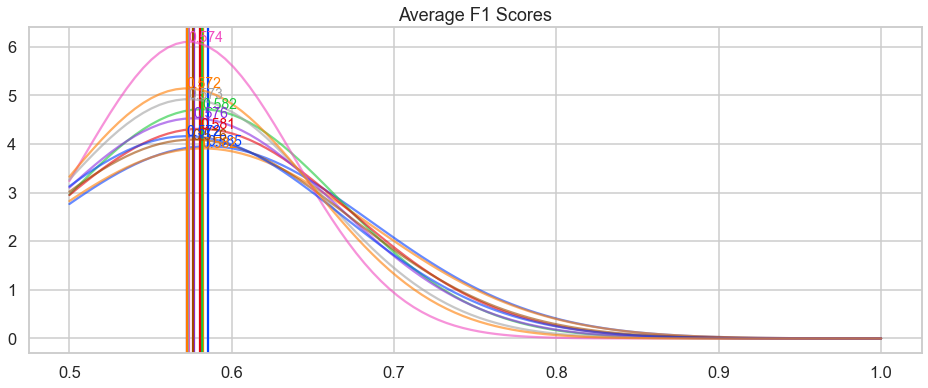

In [15]:
plot_some_tune_results(top_n_df, (0.5, 1.0))

In [16]:
%load_ext tensorboard
from tensorboard import notebook 
%tensorboard --logdir "~/ray_results/seg_facies"
notebook.display(height=1000)

Reusing TensorBoard on port 6006 (pid 9211), started 0:24:26 ago. (Use '!kill 9211' to kill it.)

Selecting TensorBoard with logdir ~/ray_results/seg_facies (started 0:24:26 ago; port 6006, pid 9211).


In [17]:
ray.shutdown()